# Exclusion lmits

Plot saved to /Users/zjj/Desktop/CnuB/code/../plots/all-flux-m1-0.1eV.pdf


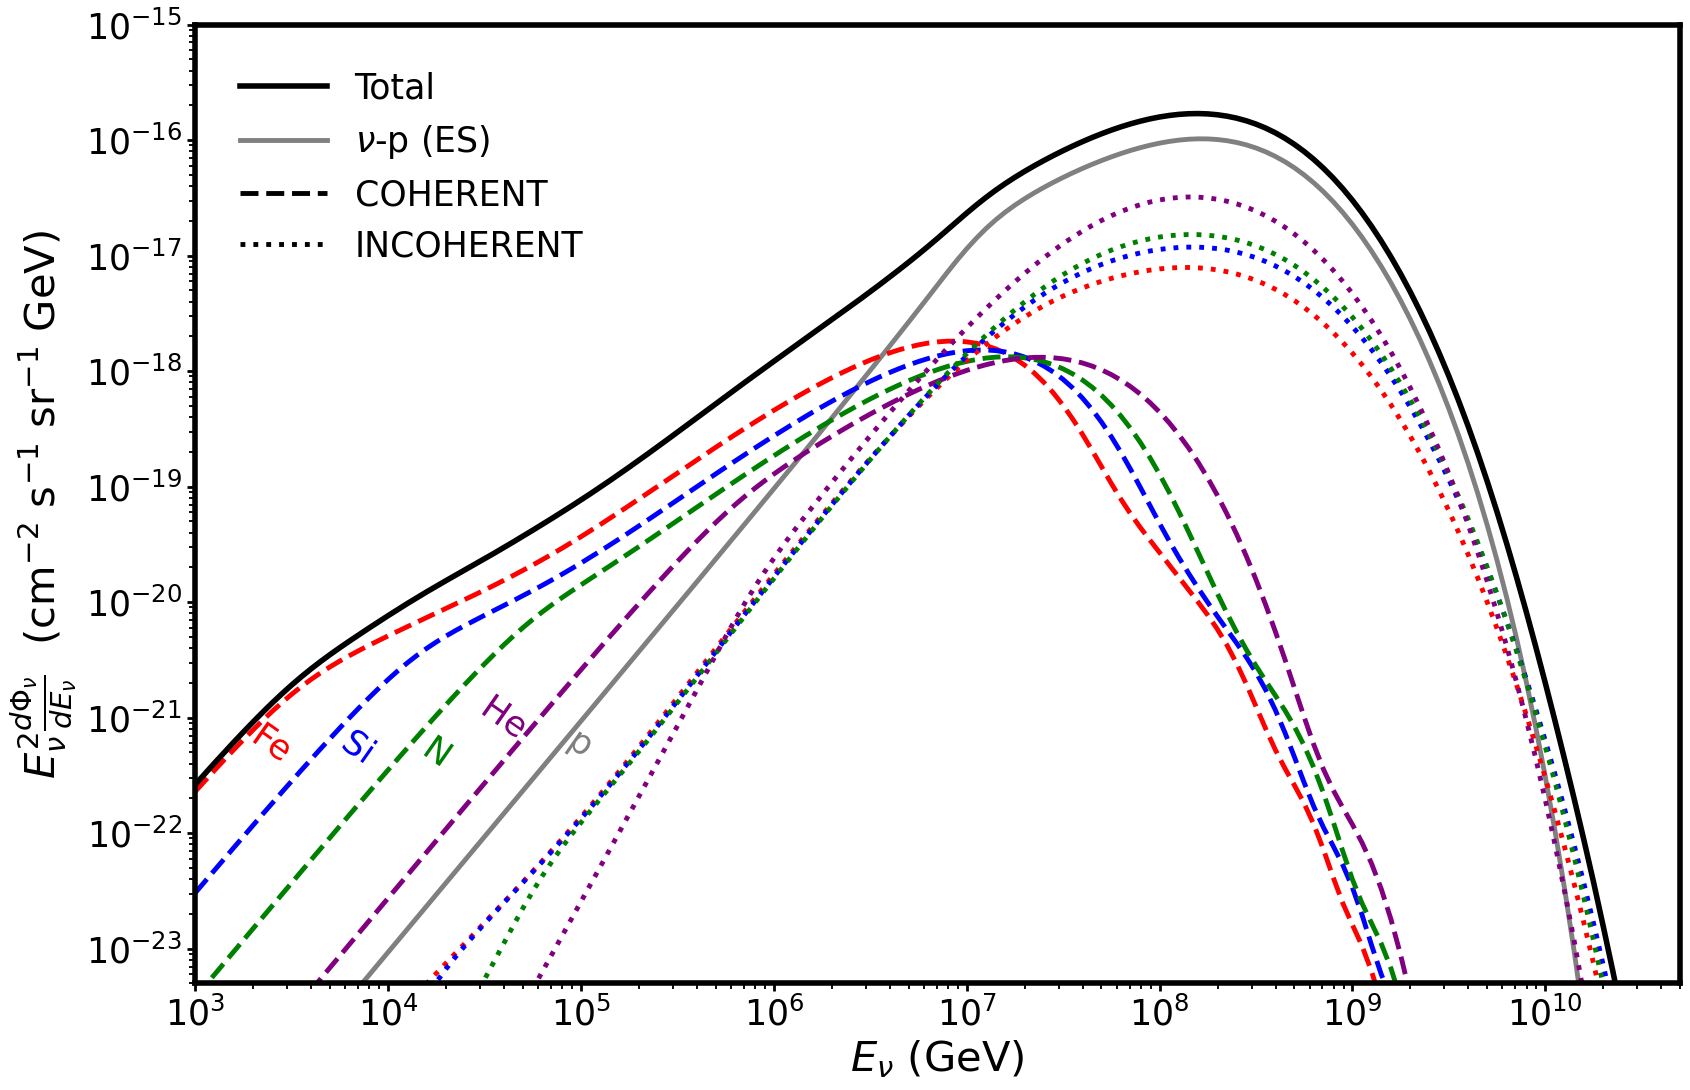

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patheffects import withStroke
from matplotlib.lines import Line2D # Needed for custom legend
import os

# --- Configuration ---
# Line Widths
line_lw = 3.5   # Base line width for data series
sum_line_lw = 4.0 # Line width for the sum line
spine_lw = 4.0   # Line width for the axis border/spines

# Font Sizes
tick_fs = 25    # Axis tick numbers (e.g., 10^3, 10^-16)
label_fs = 30   # Axis labels (e.g., E_nu [GeV])
text_fs = 25    # In-plot text labels (e.g., Fe, Si, p)
legend_fs = 25 # Legend text

# --- Modified PlotConstraint Function ---
# Uses the configured line_lw
def PlotConstraint(ax, filepath, lw=line_lw, edgecolor='darkgreen', edgealpha=1, linestyle='-',
                 zorder=0, transform_y=False):
    """Loads data, optionally transforms y, and plots the line."""
    try:
        dat = np.loadtxt(filepath, delimiter=',') # Specify comma as delimiter
        if transform_y:
            dat[:, 1] = dat[:, 1] * (dat[:, 0] ** 2)
            # dat[:, 1] = np.maximum(dat[:, 1], 1e-40) # Optional floor value

        ax.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw, alpha=edgealpha, zorder=zorder)
        return dat
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        print("Returning None, this might affect the sum calculation.")
        return None

# --- Main Script ---
# Create figure
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup File Paths --- (Ensure these are correct)
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(script_dir, '../data/')
plot_dir = os.path.join(script_dir, '../plots/')
os.makedirs(plot_dir, exist_ok=True)

# --- Colors ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd'] # Blue, Orange, Green, Purple
gray_color = 'gray'
black_color = 'black'
new_colors = {'Fe': 'red', 'Si': 'blue', 'N': 'green', 'He': 'purple'}

# --- Path Effects for Text ---
path_effects = [withStroke(linewidth=3, foreground='white')] # Keep stroke reasonable

# --- Plotting Data ---
all_data = []

# Plot 1: ν-Fe ES (Solid Gray)
filepath = os.path.join(data_dir, 'SFR-100-ES-proton-total.csv')
dat_es = PlotConstraint(ax, filepath, edgecolor=gray_color, linestyle='-', transform_y=True)
if dat_es is not None:
    all_data.append(dat_es)
    # Add 'p' label next to the ν-Fe ES line
    ax.text(1e5, 6e-22, r'p', fontsize=text_fs, color=gray_color,
            rotation=-35, path_effects=path_effects, clip_on=True,
            alpha=1.0, rotation_mode='anchor', ha='center', va='center')

# --- COH Plots (Dashed) ---
coh_files = {
    'Fe': 'SFR-100-COH-fe-total.csv',
    'Si': 'SFR-100-COH-si-total.csv',
    'N':  'SFR-100-COH-n-total.csv',
    'He': 'SFR-100-COH-he-total.csv'
}
coh_colors = new_colors
# Adjusted positions slightly based on potential font size increase
coh_label_params = {
    'Fe': (2.5e3, 6e-22, -35), # Y slightly increased
    'Si': (7e3, 5.5e-22, -35),# Y slightly increased
    'N':  (1.8e4, 5e-22, -35), # Y slightly increased
    'He': (4e4, 1e-21, -35) # Y slightly increased
}
for i, (element, filename) in enumerate(coh_files.items()):
    filepath = os.path.join(data_dir, filename)
    dat = PlotConstraint(ax, filepath, edgecolor=coh_colors[element], linestyle='--', transform_y=True)
    if dat is not None:
        all_data.append(dat)
        x_pos, y_pos, rot = coh_label_params[element]
        # Apply configured text font size (text_fs)
        ax.text(x_pos, y_pos, element, fontsize=text_fs, color=coh_colors[element],
                rotation=rot, path_effects=path_effects, clip_on=True,
                alpha=1.0, rotation_mode='anchor', ha='center', va='center')

# --- INCOH Plots (Dotted) ---
incoh_files = {
    'Fe': 'SFR-100-INCOH-fe-total.csv',
    'Si': 'SFR-100-INCOH-si-total.csv',
    'N':  'SFR-100-INCOH-n-total.csv',
    'He': 'SFR-100-INCOH-he-total.csv'
}
incoh_colors = new_colors
for i, (element, filename) in enumerate(incoh_files.items()):
    filepath = os.path.join(data_dir, filename)
    dat = PlotConstraint(ax, filepath, edgecolor=incoh_colors[element], linestyle=':', transform_y=True)
    if dat is not None: all_data.append(dat)

# --- Calculate and Plot Sum ---
if all_data:
    base_x = all_data[0][:, 0]
    sum_y = np.zeros_like(base_x)
    valid_sum = True
    for dat in all_data:
        if dat is not None and np.array_equal(dat[:, 0], base_x):
            sum_y += np.maximum(dat[:, 1], 0)
        elif dat is not None:
            print(f"Warning: X-values mismatch for summation. Interpolation needed but not implemented.")
            print("Skipping data from summation due to X mismatch or loading error.")
            valid_sum = False

    if valid_sum and len(all_data) > 0:
        # Apply configured sum line width (sum_line_lw)
        ax.plot(base_x, sum_y, linestyle='-', color=black_color, lw=sum_line_lw, zorder=10, label='Sum')
    else:
        print("Summation could not be performed correctly due to data loading errors or x-value mismatches.")
else:
    print("No data loaded, cannot calculate or plot sum.")

# --- Set Axes ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e3, 0.5*1e11])
ax.set_ylim([5e-24, 1e-15])
# Apply configured axis label font size (label_fs)
ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$E_{\nu}^{2} \frac{d\Phi_{\nu}}{dE_{\nu}}$  (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV)', fontsize=label_fs)
# Apply configured tick label font size (tick_fs)
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=6) # Make ticks visible
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=4) # Make minor ticks visible

# --- Thicken Axis Spines (Border) ---
# Apply configured spine line width (spine_lw)
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

# --- Create Custom Legend ---
# Use configured line widths and legend font size (legend_fs)
legend_elements = [
    Line2D([0], [0], color=black_color, lw=sum_line_lw, linestyle='-', label='Total'),
    Line2D([0], [0], color=gray_color, lw=line_lw, linestyle='-', label=r'$\nu$-p (ES)'),
    Line2D([0], [0], color='k', lw=line_lw, linestyle='--', label='COHERENT'),
    Line2D([0], [0], color='k', lw=line_lw, linestyle=':', label='INCOHERENT'),
    ]

# Adjusted legend with precise coordinates
ax.legend(
    handles=legend_elements,
    loc='upper right',
    fontsize=legend_fs,
    frameon=False,
    handlelength=2.5,
    handletextpad=0.8,
    labelspacing=0.5,
    borderpad=0.3,
    bbox_to_anchor=(0.28, 0.98)  # Slightly offset from upper-right corner
)
# --- Final Adjustments ---
plt.tight_layout()

# --- Save and Show ---
output_filename = os.path.join(plot_dir, 'all-flux-m1-0.1eV.pdf')
plt.savefig(output_filename, transparent=False, bbox_inches='tight')
print(f"Plot saved to {output_filename}")
plt.show()

Processing 4 files for 'SFR-100-COH'...
Plotted data for 'SFR-100-COH'.
Processing 4 files for 'SFR-100-INCOH'...
Plotted data for 'SFR-100-INCOH'.
Plotted sum for 'SFR-100'.
Processing 4 files for 'SFR-50-COH'...
Plotted data for 'SFR-50-COH'.
Processing 4 files for 'SFR-50-INCOH'...
Plotted data for 'SFR-50-INCOH'.
Plotted sum for 'SFR-50'.
Processing 4 files for 'SFR-10-COH'...
Plotted data for 'SFR-10-COH'.
Processing 4 files for 'SFR-10-INCOH'...
Plotted data for 'SFR-10-INCOH'.
Plotted sum for 'SFR-10'.
Note: Final Y-axis limits set to (1e-23, 1e-15).
Saved plot to /Users/zjj/Desktop/CnuB/code/../plots/flux-COH-INCOH.pdf


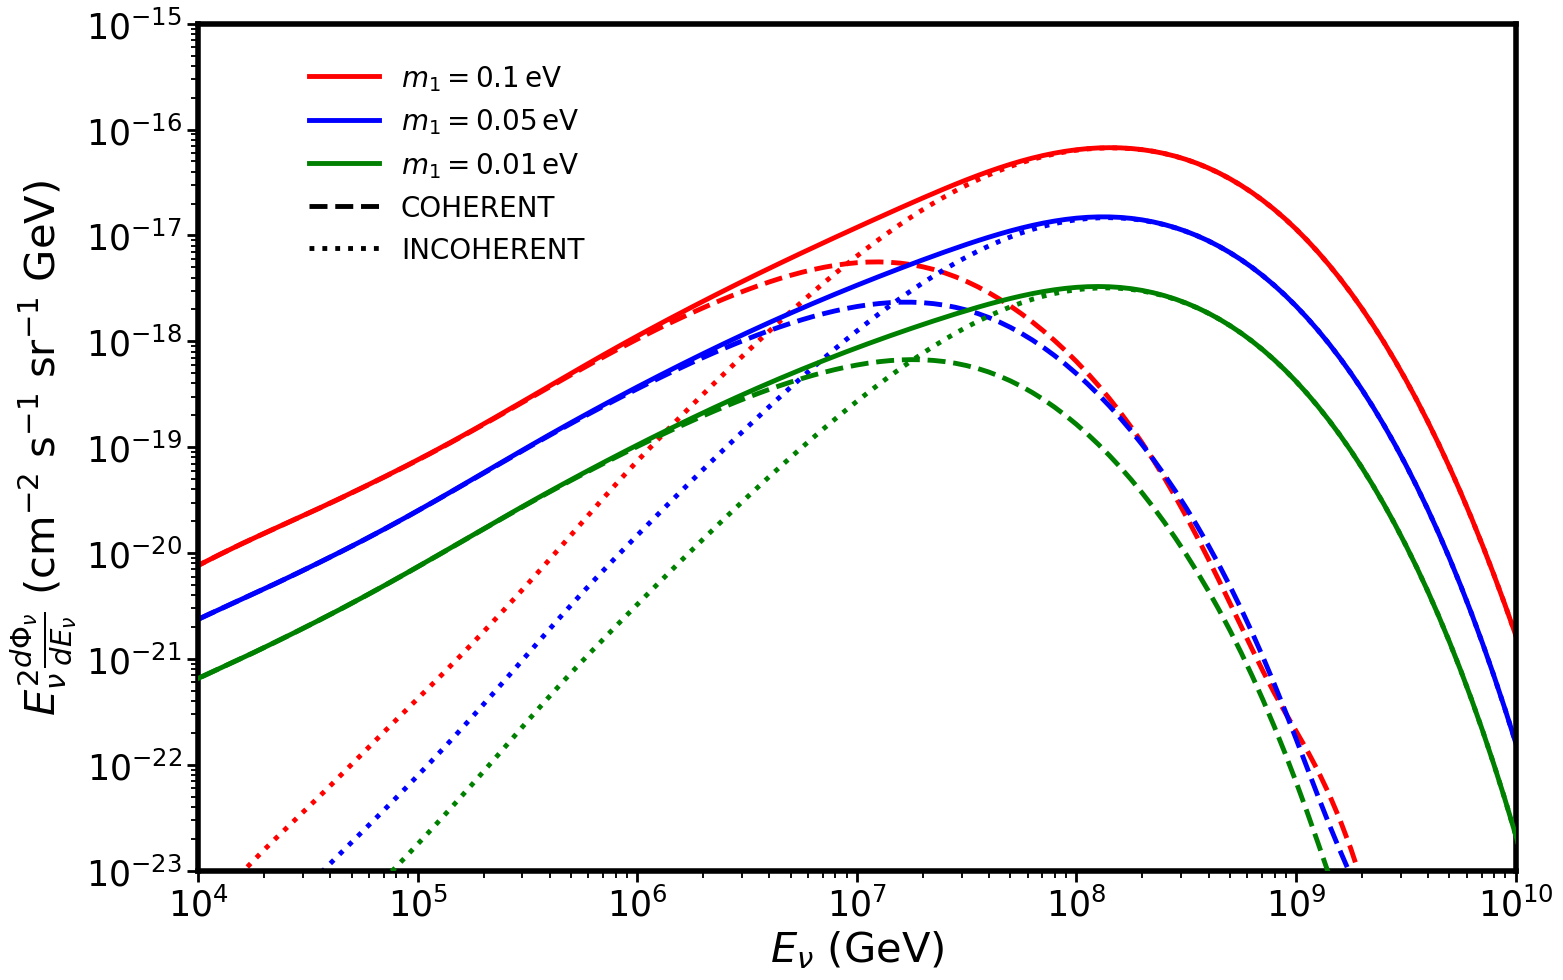

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D  # For custom legend
import glob
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for SFR lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers
label_fs = 30       # Axis labels
inline_text_fs = 25 # In-plot text labels (unused now)
legend_fs = 20      # Legend font size

# --- Style File Check ---
style_path = 'sty.mplstyle'
if os.path.exists(style_path):
    plt.style.use(style_path)
    print(f"Using style file: {style_path}")
else:
    print(f"Warning: Style file '{style_path}' not found. Using default styles.")

# --- Path Effects for Text ---
text_path_effects = [pe.withStroke(linewidth=3, foreground='white')]

# --- Modified plot_sfr_sum Function ---
def plot_sfr_sum(ax, data_dir, prefix, subcategories, colors, linestyles, zorder_base=1, return_sum=False):
    summed_y = None
    base_x = None
    for subcategory, color, linestyle in zip(subcategories, colors, linestyles):
        search_pattern = os.path.join(data_dir, f"{prefix}-{subcategory}-*.csv")
        file_list = sorted(glob.glob(search_pattern))

        if not file_list:
            print(f"Warning: No files found for pattern '{search_pattern}'")
            continue

        print(f"Processing {len(file_list)} files for '{prefix}-{subcategory}'...")

        sum_y = None
        first_file = True

        for filepath in file_list:
            try:
                dat = np.loadtxt(filepath, delimiter=',')
                if dat.ndim != 2 or dat.shape[1] < 2 or dat.shape[0] == 0:
                    continue
                current_x = dat[:, 0]
                current_y = dat[:, 1]
                if first_file:
                    base_x = current_x
                    sum_y = current_y.copy()
                    first_file = False
                else:
                    if len(base_x) != len(current_x) or not np.allclose(base_x, current_x, atol=1e-8, rtol=1e-5):
                        print(f"Error: X-values mismatch in {os.path.basename(filepath)}. Skipping.")
                        continue
                    sum_y += current_y
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
                continue

        if sum_y is None or base_x is None:
            print(f"Warning: No valid data summed for '{prefix}-{subcategory}'.")
            continue

        # Transform y by multiplying with x^2
        transformed_y = sum_y * (base_x ** 2)

        # Accumulate for sum if requested
        if return_sum:
            if summed_y is None:
                summed_y = transformed_y.copy()
            else:
                summed_y += transformed_y

        # Plotting individual lines
        if np.any(np.isfinite(transformed_y)):
            ax.plot(base_x, transformed_y, color=color, linestyle=linestyle, lw=base_line_lw, zorder=zorder_base)
            print(f"Plotted data for '{prefix}-{subcategory}'.")
        else:
            print(f"Warning: No finite values to plot for '{prefix}-{subcategory}'.")

    if return_sum and summed_y is not None:
        return base_x, summed_y
    return None, None

# --- Main Plotting Logic ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(base_dir, '../data/')
plot_dir = os.path.join(base_dir, '../plots/')
os.makedirs(plot_dir, exist_ok=True)

# --- SFR Definitions ---
sfr_prefixes = ['SFR-100', 'SFR-50', 'SFR-10']  # Updated prefixes
subcategories = ['COH', 'INCOH']
sfr_colors = ['red', 'blue', 'green']  # Red for SFR-100, Blue for SFR-50, Green for SFR-10
sfr_linestyles = ['--', ':']  # Dashed for COH, Dotted for INCOH

# --- Plot SFR Lines ---
for i, prefix in enumerate(sfr_prefixes):
    base_x, summed_y = plot_sfr_sum(
        ax, data_dir, prefix,
        subcategories=subcategories,
        colors=[sfr_colors[i], sfr_colors[i]],
        linestyles=sfr_linestyles,
        zorder_base=i + 1,
        return_sum=True
    )
    if summed_y is not None:
        ax.plot(base_x, summed_y, color=sfr_colors[i], linestyle='-', lw=base_line_lw, zorder=i + 1.5)
        print(f"Plotted sum for '{prefix}'.")

# --- Axis Settings ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e4, 1e10])
ax.set_ylim([1e-23, 1e-15])
print(f"Note: Final Y-axis limits set to {ax.get_ylim()}.")

ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$E_{\nu}^{2} \frac{d\Phi_{\nu}}{dE_{\nu}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV)', fontsize=label_fs)
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=8)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=5)

# Thicken spines
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

# Set tick locators
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100))

# --- Create Custom Legend ---
legend_elements = [
    Line2D([0], [0], color='red', lw=base_line_lw, linestyle='-', label=r'$m_1=0.1 \, \mathrm{eV}$'),
    Line2D([0], [0], color='blue', lw=base_line_lw, linestyle='-', label=r'$m_1=0.05 \, \mathrm{eV}$'),
    Line2D([0], [0], color='green', lw=base_line_lw, linestyle='-', label=r'$m_1=0.01 \, \mathrm{eV}$'),
    Line2D([0], [0], color='k', lw=base_line_lw, linestyle='--', label='COHERENT'),
    Line2D([0], [0], color='k', lw=base_line_lw, linestyle=':', label='INCOHERENT')
]

# Adjusted legend with precise coordinates
ax.legend(
    handles=legend_elements,
    loc='upper right',
    fontsize=legend_fs,
    frameon=False,
    handlelength=2.5,
    handletextpad=0.8,
    labelspacing=0.5,
    borderpad=0.3,
    bbox_to_anchor=(0.31, 0.98)  # Slightly offset from upper-right corner
)

# --- Save Plot ---
output_pdf = os.path.join(plot_dir, 'flux-COH-INCOH.pdf')
plt.savefig(output_pdf, transparent=False, bbox_inches='tight')
print(f"Saved plot to {output_pdf}")

# --- Display Plot ---
plt.show()

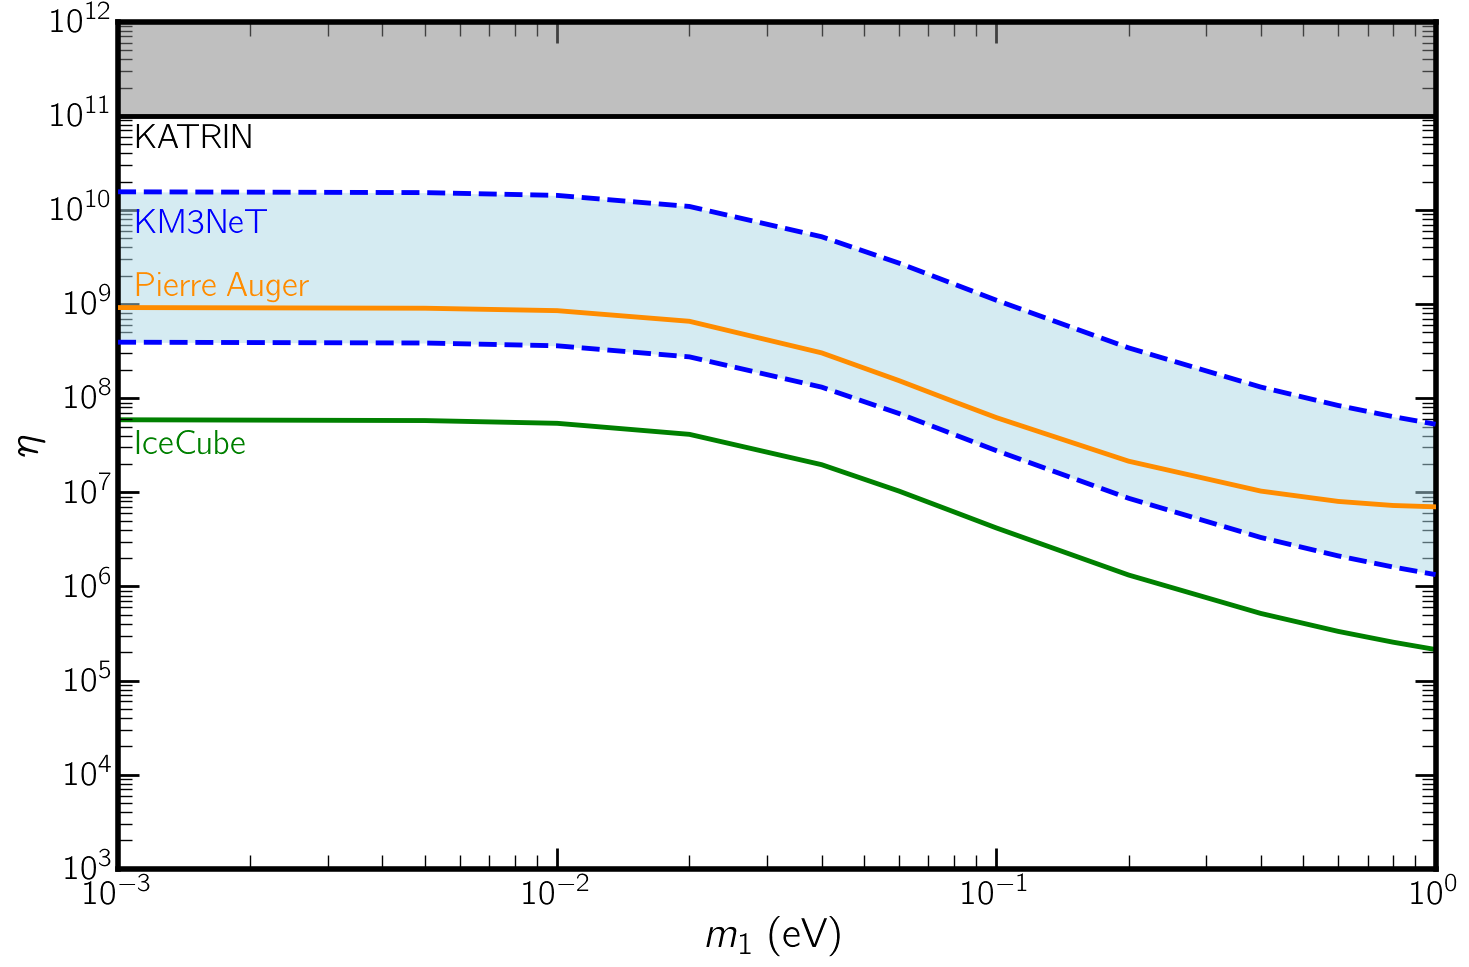

In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for plotted lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers font size
label_fs = 30       # Axis labels font size
inline_text_fs = 25 # In-plot text labels font size
legend_fs = 20      # Legend font size (for potential future use)

plt.style.use('sty3.mplstyle')

def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1,
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=None,
                   text_on=True, label='', label_pos=[1e1, 1e-33], fontsize=inline_text_fs,
                   rotation=30, text_path_effects=None, textalpha=1, linestyle='-'):
    """
    Plot a constraint curve from a CSV file.
    """
    try:
        # Load the CSV file, specifying comma as the delimiter
        dat = np.loadtxt(filepath, delimiter=',')
        if filled:
            # Fill above the curve: from dat[:, 1] to a large value
            ax.fill_between(dat[:, 0], dat[:, 1], y2=1e15, color=facecolor, alpha=facealpha, zorder=fill_zorder, lw=0)
        ax.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw, path_effects=path_effects, alpha=edgealpha, zorder=zorder)

        if text_on:
            ax.text(label_pos[0], label_pos[1], label, fontsize=fontsize,
                    color=edgecolor, rotation=rotation, path_effects=text_path_effects, clip_on=True, alpha=textalpha, rotation_mode='anchor')
        return dat
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup File Path ---
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(script_dir, '../data/')
filepath_icecube = os.path.join(data_dir, 'mv0_eta_SFR_icecube.csv')
filepath_auger = os.path.join(data_dir, 'mv0_eta_SFR_auger.csv')
filepath_km3net_up = os.path.join(data_dir, 'mv0_eta_SFR_km3net-up.csv')
filepath_km3net_down = os.path.join(data_dir, 'mv0_eta_SFR_km3net-down.csv')

# --- Plot IceCube Data (Green Line, No Fill) ---
PlotConstraint(ax, filepath_icecube, filled=False, edgecolor='green', facecolor='lightblue', facealpha=0.5,
               label='IceCube', label_pos=[1.1e-3, 2.5e7], rotation=0, fontsize=inline_text_fs, zorder=1, lw=base_line_lw)

# --- Plot Auger Data (Orange Line, No Fill) ---
PlotConstraint(ax, filepath_auger, filled=False, edgecolor='#FF8C00', facecolor='lightblue', facealpha=0.7,
               label='Pierre Auger', label_pos=[1.1e-3, 1.2e9], rotation=0, fontsize=inline_text_fs, zorder=5, lw=base_line_lw)

# --- Plot KM3NeT Up and Down (Blue Lines, Fill Between) ---
# Plot the upper line with the KM3NeT label
dat_up = PlotConstraint(ax, filepath_km3net_up, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                        label='KM3NeT', label_pos=[1.1e-3, 5.5e9], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, linestyle='--')

# Plot the lower line (no label to avoid duplication)
dat_down = PlotConstraint(ax, filepath_km3net_down, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                          label='', label_pos=[1.1e-3, 4.5e9], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, text_on=False, linestyle='--')

# Fill between the upper and lower lines with light blue
if dat_up is not None and dat_down is not None:
    ax.fill_between(dat_up[:, 0], dat_down[:, 1], dat_up[:, 1], color='lightblue', alpha=0.5, zorder=2, lw=0)

# --- Add Horizontal Line for KATRIN at y = 9.95e10 (Gray Solid Line) with Fill Above ---
katrin_y = 9.95e10
ax.axhline(y=katrin_y, color='black', linestyle='-', lw=base_line_lw, zorder=3)

# Add gray fill above the KATRIN line
x_range = ax.get_xlim()  # Get the x-axis range for filling
ax.fill_between(x_range, katrin_y, 1e15, color='gray', alpha=0.5, zorder=2, lw=0)

# Add KATRIN label
ax.text(1.1e-3, 4.5e10, 'KATRIN', fontsize=inline_text_fs, color='black', rotation=0, clip_on=True)

# --- Set Axes ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-3, 1e0])  # Adjusted for mv0 range
ax.set_ylim([1e3, 1e12])  # Adjusted for eta range
ax.set_xlabel(r'$m_1$ (eV)', fontsize=label_fs)
ax.set_ylabel(r'$\eta$', fontsize=label_fs)

# Apply tick font size
ax.tick_params(axis='both', which='major', labelsize=tick_fs)
ax.tick_params(axis='both', which='minor', labelsize=tick_fs)

# Apply spine width
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)

plt.savefig('../plots/mv0_eta_SFR_combined.pdf', transparent=False, bbox_inches='tight')
plt.show()

--- Applying y-axis scaling factor for all-flavor flux: 3.0 ---
--- Scaling both data point centers AND error lengths for log-scale visual consistency ---
Using style file: sty.mplstyle
Using Overdensity Factor: 1.0e+08
Data directory resolved to: /Users/zjj/Desktop/CnuB/code/../data/
Plot directory resolved to: /Users/zjj/Desktop/CnuB/code/../plots/
Processing 9 files for prefix 'SFR-100'...
Plotted scaled summed and transformed data for 'SFR-100'.
Processing 9 files for prefix 'SFR-50'...
Plotted scaled summed and transformed data for 'SFR-50'.
Processing 9 files for prefix 'SFR-10'...
Plotted scaled summed and transformed data for 'SFR-10'.
Note: Final Y-axis limits set to (1e-10, 1e-06) (scaled).
Saved scaled plot to /Users/zjj/Desktop/CnuB/code/../plots/all-flux-SFR.pdf


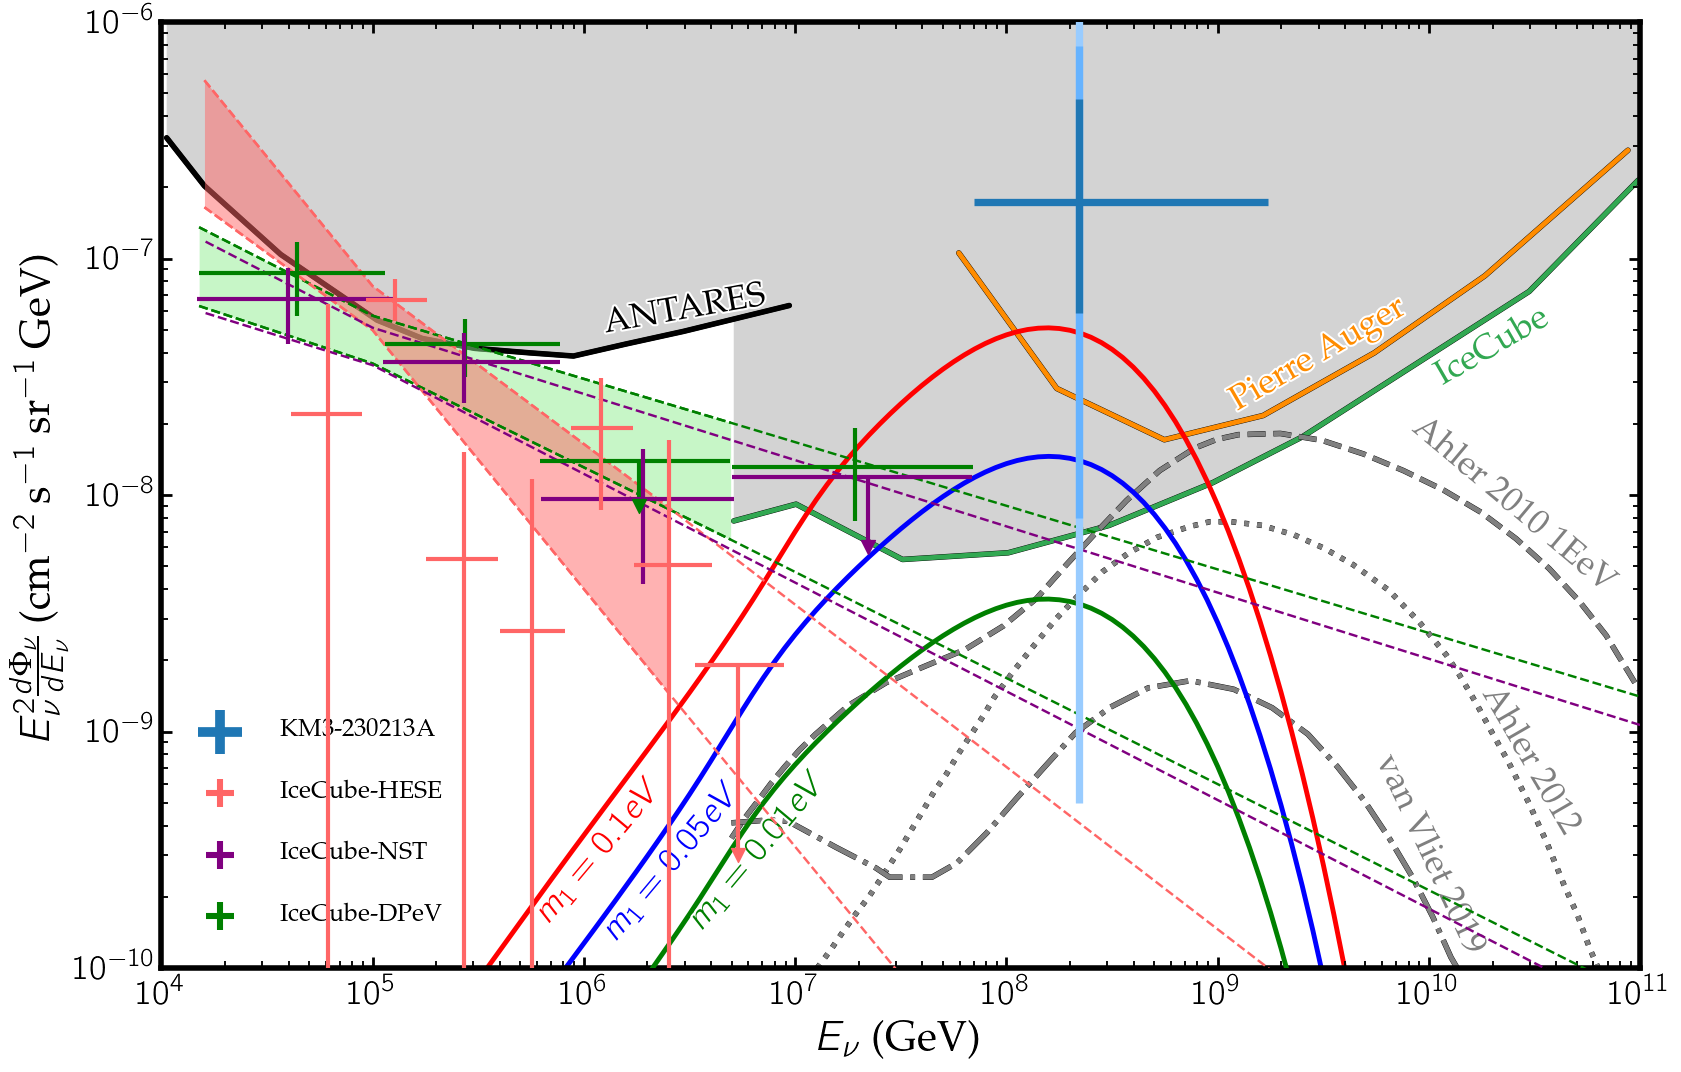

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D  # For custom legend
from matplotlib.patches import Rectangle # For filled box legend entries
import glob
import os

# --- Configuration ---
base_line_lw = 3.5
thin_line_lw = base_line_lw / 2
km3net_lw = base_line_lw * 1.5
spine_lw = 4.0
tick_fs = 25
label_fs = 30
inline_text_fs = 25
legend_fs = 18
# --- Legend Marker Specific Configurations ---
marker_size = 20    # Size for '+' markers
cross_lw = km3net_lw / 1.2 # Linewidth for '+' markers
box_size = 0.04     # Size of the filled box markers
box_lw = 1.5 * 3    # Linewidth for box markers (Increased x3)
line_lw = base_line_lw # Linewidth for line markers (Not used anymore for Auger)

# --- Scaling Factor for All-Flavor Flux ---
scaling_factor = 3.0 # Multiply y-values by this factor
print(f"--- Applying y-axis scaling factor for all-flavor flux: {scaling_factor:.1f} ---")
print("--- Scaling both data point centers AND error lengths for log-scale visual consistency ---")

# --- Style File Check ---
style_path = 'sty.mplstyle'
if os.path.exists(style_path):
    plt.style.use(style_path)
    print(f"Using style file: {style_path}")
else:
    print(f"Warning: Style file '{style_path}' not found. Using default Matplotlib styles.")

# --- Path Effects for Text ---
text_path_effects = [pe.withStroke(linewidth=3, foreground='white')]

# --- PlotConstraint Function (Scaled) ---
def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1e6, # Increase y2 substantially
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                   label_text='', label_pos=(1e7, 1e-8), rotation=0, text_color=None,
                   label='', textalpha=1, linestyle='-'):
    global scaling_factor
    try:
        dat = np.loadtxt(filepath, delimiter=',')
        dat[:, 1] *= scaling_factor # Scale Y data
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None

    line, = plt.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw,
                     path_effects=path_effects, alpha=edgealpha, zorder=zorder)

    if filled:
        actual_fill_zorder = min(zorder - 0.1, fill_zorder)
        # Also scale the fill boundary if it's not effectively infinity
        fill_y2 = y2 * scaling_factor if y2 < 1e5 else y2 # Avoid scaling if y2 is already huge
        plt.fill_between(dat[:, 0], dat[:, 1], y2=fill_y2, color=facecolor, alpha=facealpha, zorder=actual_fill_zorder, lw=0)

    if label_text:
        text_c = text_color if text_color else edgecolor
        scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
        ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs,
                color=text_c, rotation=rotation, path_effects=text_path_effects,
                clip_on=True, alpha=textalpha, rotation_mode='anchor', ha='center', va='center')
    return line

# --- plot_sfr_sum Function (Scaled) ---
def plot_sfr_sum(ax, data_dir, prefix, color, linestyle,
                 label_text='', label_pos=(1e9, 1e-10), rotation=-45,
                 overdensity_factor=1.0, lw=base_line_lw, zorder=1):
    global scaling_factor
    search_pattern = os.path.join(data_dir, f"{prefix}-*.csv")
    file_list = sorted(glob.glob(search_pattern))
    if not file_list: print(f"Warning: No files found for prefix '{prefix}' with pattern '{search_pattern}'"); return
    print(f"Processing {len(file_list)} files for prefix '{prefix}'...")
    sum_y, base_x, first_file = None, None, True
    for filepath in file_list:
        try:
            dat = np.loadtxt(filepath, delimiter=',')
            if dat.ndim != 2 or dat.shape[1] < 2 or dat.shape[0] == 0: continue
            current_x, current_y = dat[:, 0], dat[:, 1]
            if first_file: base_x, sum_y, first_file = current_x, current_y.copy(), False
            else:
                if len(base_x) != len(current_x) or not np.allclose(base_x, current_x, atol=1e-8, rtol=1e-5):
                    print(f"Error: X-values mismatch in {os.path.basename(filepath)} for '{prefix}'. Skipping."); continue
                sum_y += current_y
        except Exception as e: print(f"Error processing {filepath}: {e}"); continue
    if sum_y is None or base_x is None: print(f"Warning: No sum for '{prefix}'."); return

    transformed_y = sum_y * (base_x ** 2) * overdensity_factor * scaling_factor # Scale Y data

    if np.any(np.isfinite(transformed_y)):
        ax.plot(base_x, transformed_y, color=color, linestyle=linestyle, lw=lw, zorder=zorder)
        print(f"Plotted scaled summed and transformed data for '{prefix}'.")
        if label_text:
            scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
            ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs, color=color, rotation=rotation,
                    path_effects=text_path_effects, clip_on=True, alpha=1.0, rotation_mode='anchor', ha='center', va='center')
    else: print(f"Warning: No finite values to plot for prefix '{prefix}'.")


# --- Main Plotting Logic ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

overdensity_factor = 1e8
print(f"Using Overdensity Factor: {overdensity_factor:.1e}")
base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_dir_rel, plot_dir_rel = '../data/', '../plots/'
data_dir, plot_dir = os.path.join(base_dir, data_dir_rel), os.path.join(base_dir, plot_dir_rel)
plot_png_dir = os.path.join(plot_dir, 'plots_png/')
os.makedirs(plot_dir, exist_ok=True); os.makedirs(plot_png_dir, exist_ok=True)
print(f"Data directory resolved to: {data_dir}")
print(f"Plot directory resolved to: {plot_dir}")

# --- Define Colors Consistently ---
icecube_color = '#32a852'
auger_color = '#FF8C00'
antares_color = 'black'
fill_color = 'lightgray'

# --- Plot IceCube, Auger, ANTARES, and New Lines (Scaled inside PlotConstraint) ---
icecube_label_pos, auger_label_pos, ANTARES95_label_pos = (2e10, 1.4e-8), (3e9, 1.3e-8), (3e6, 2e-8)
ahler2010_label_pos, ahler2012_label_pos, vliet2019_label_pos = (2.5e10, 3e-9), (3e10, 2.5e-10), (1e10, 1e-10)  # Individual positions to avoid overlap
icecube_rotation, auger_rotation, ANTARES95_rotation = 30, 30, 10
PlotConstraint(ax, os.path.join(data_dir, 'IceCube-12.6.csv'), filled=True, label_text='IceCube', label_pos=icecube_label_pos, rotation=icecube_rotation, edgecolor=icecube_color, facecolor=fill_color, zorder=0)
PlotConstraint(ax, os.path.join(data_dir, 'Auger.csv'), filled=False, label_text='Pierre Auger', text_color='#FF8C00', label_pos=auger_label_pos, rotation=auger_rotation, edgecolor=auger_color, zorder=0.5)
PlotConstraint(ax, os.path.join(data_dir, 'ANTARES95.csv'), filled=True, label_text='ANTARES', label_pos=ANTARES95_label_pos, rotation=ANTARES95_rotation, edgecolor=antares_color, facecolor=fill_color, zorder=0)
# Add new lines for Ahler 2010, Ahler 2012, and Vliet 2019 with individual label positions
PlotConstraint(ax, os.path.join(data_dir, 'ahler2010.csv'), filled=False, label_text='Ahler 2010 1EeV', label_pos=ahler2010_label_pos, rotation=-40, edgecolor='gray', linestyle='--', zorder=0)  # Dashed line
PlotConstraint(ax, os.path.join(data_dir, 'ahler2012.csv'), filled=False, label_text='Ahler 2012', label_pos=ahler2012_label_pos, rotation=-60, edgecolor='gray', linestyle=':', zorder=0)  # Dotted line
PlotConstraint(ax, os.path.join(data_dir, 'vliet2019.csv'), filled=False, label_text='van Vliet 2019', label_pos=vliet2019_label_pos, rotation=-65, edgecolor='gray', linestyle='-.', zorder=0)  # Dash-dot line


# --- SFR Definitions & Plotting (Scaled inside plot_sfr_sum) ---
sfr_prefixes = ['SFR-100', 'SFR-50', 'SFR-10']; sfr_colors = ['red', 'blue', 'green']; sfr_linestyles = ['-', '-', '-']
sfr_label_texts = {'SFR-100': r'$m_1=0.1eV$', 'SFR-50': r'$m_1=0.05eV$', 'SFR-10': r'$m_1=0.01eV$'}
sfr_label_params = {'SFR-100': (1.15e6, 1e-10, +50), 'SFR-50': (2.55e6, 9e-11, +50), 'SFR-10': (6.5e6, 1e-10, +50)}
for i, prefix in enumerate(sfr_prefixes):
    params = sfr_label_params.get(prefix, (1e9, 1e-11, -45)); label_txt = sfr_label_texts.get(prefix, prefix)
    plot_sfr_sum(ax, data_dir, prefix, color=sfr_colors[i % len(sfr_colors)], linestyle=sfr_linestyles[i % len(sfr_linestyles)], label_text=label_txt, label_pos=(params[0], params[1]), rotation=params[2], overdensity_factor=overdensity_factor, zorder=i + 1)


# --- Plot DPeV Fill (Scaled) ---
try:
    dpev_upper = np.loadtxt(os.path.join(data_dir, 'DpeV-up.csv'), delimiter=','); dpev_lower = np.loadtxt(os.path.join(data_dir, 'DpeV-down.csv'), delimiter=',')
    dpev_upper[:, 1] *= scaling_factor # Scale Y data
    dpev_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(dpev_upper[:, 0], dpev_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(dpev_upper[:, 0], dpev_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(dpev_lower[:, 0], dpev_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(dpev_upper[:, 0], dpev_lower[:, 1], dpev_upper[:, 1], color='lightgreen', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: DPeV x values misaligned.")
except Exception as e: print(f"Error processing DPeV files: {e}")

# --- Plot HEST Fill (Scaled) ---
try:
    hest_upper = np.loadtxt(os.path.join(data_dir, 'HEST-up.csv'), delimiter=','); hest_lower = np.loadtxt(os.path.join(data_dir, 'HEST-down.csv'), delimiter=',')
    hest_upper[:, 1] *= scaling_factor # Scale Y data
    hest_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(hest_upper[:, 0], hest_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(hest_upper[:, 0], hest_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(hest_lower[:, 0], hest_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(hest_upper[:, 0], hest_lower[:, 1], hest_upper[:, 1], color='#FF6666', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: HEST x values misaligned.")
except Exception as e: print(f"Error processing HEST files: {e}")

# --- Plot Dashed Lines (DPeVall, HESTall, NSTall) (Scaled) ---
try:
    dpevall_upper = np.loadtxt(os.path.join(data_dir, 'DPeVall-up.csv'), delimiter=','); dpevall_lower = np.loadtxt(os.path.join(data_dir, 'DPeVall-down.csv'), delimiter=',')
    hestall_upper = np.loadtxt(os.path.join(data_dir, 'HESTall-up.csv'), delimiter=','); hestall_lower = np.loadtxt(os.path.join(data_dir, 'HESTall-down.csv'), delimiter=',')
    nstall_upper = np.loadtxt(os.path.join(data_dir, 'NSTall-up.csv'), delimiter=','); nstall_lower = np.loadtxt(os.path.join(data_dir, 'NSTall-down.csv'), delimiter=',')

    dpevall_upper[:, 1] *= scaling_factor; dpevall_lower[:, 1] *= scaling_factor # Scale Y
    hestall_upper[:, 1] *= scaling_factor; hestall_lower[:, 1] *= scaling_factor # Scale Y
    nstall_upper[:, 1] *= scaling_factor; nstall_lower[:, 1] *= scaling_factor # Scale Y

    ax.plot(dpevall_upper[:, 0], dpevall_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(dpevall_lower[:, 0], dpevall_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(hestall_upper[:, 0], hestall_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(hestall_lower[:, 0], hestall_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(nstall_upper[:, 0], nstall_upper[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(nstall_lower[:, 0], nstall_lower[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3)
except Exception as e: print(f"Error processing dashed line files: {e}")


# --- Add Special Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
x_center_green_orig, y_center_green_orig, y_lower_green_orig = 1.82e6, 4.63e-9, 3e-9
x_err_green = [[1.2e6], [3.1e6]] # X error unchanged
y_center_green_scaled = y_center_green_orig * scaling_factor # Scale center y
y_lower_green_scaled = y_lower_green_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_green_scaled - y_lower_green_scaled # Calculate scaled error length
y_err_green_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_green_orig, y_center_green_scaled, xerr=x_err_green, yerr=y_err_green_scaled, fmt=' ', color='green', ecolor='green', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_green_orig, y_lower_green_scaled, color='green', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_pink_orig, y_center_pink_orig, y_lower_pink_orig = 5.36e6, 6.36e-10, 1e-10
x_err_pink = [[2e6], [3.5e6]] # X error unchanged
y_center_pink_scaled = y_center_pink_orig * scaling_factor # Scale center y
y_lower_pink_scaled = y_lower_pink_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_pink_scaled - y_lower_pink_scaled # Calculate scaled error length
y_err_pink_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_pink_orig, y_center_pink_scaled, xerr=x_err_pink, yerr=y_err_pink_scaled, fmt=' ', color='#FF6666', ecolor='#FF6666', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_pink_orig, y_lower_pink_scaled, color='#FF6666', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_purple_orig, y_center_purple_orig, y_lower_purple_orig = 2.2e7, 3.98e-9, 2e-9
x_err_purple = [[1.7e7], [4.7e7]] # X error unchanged
y_center_purple_scaled = y_center_purple_orig * scaling_factor # Scale center y
y_lower_purple_scaled = y_lower_purple_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_purple_scaled - y_lower_purple_scaled # Calculate scaled error length
y_err_purple_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_purple_orig, y_center_purple_scaled, xerr=x_err_purple, yerr=y_err_purple_scaled, fmt=' ', color='purple', ecolor='purple', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_purple_orig, y_lower_purple_scaled, color='purple', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos


# --- Add Normal Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
error_bars = {
    'green': {'centers': [(4.4e4, 2.9e-8), (2.75e5, 1.45e-8), (1.92e7, 4.38e-9)], 'x_errs': [(2.9e4, 7e4), (1.6e5, 5e5), (1.42e7, 5e7)], 'y_errs': [(1e-8, 1e-8), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    'purple': {'centers': [(3.97e4, 2.25e-8), (2.72e5, 1.22e-8), (1.91e6, 3.2e-9)], 'x_errs': [(2.5e4, 8.6e4), (1.6e5, 5e5), (1.28e6, 3.2e6)], 'y_errs': [(8e-9, 8e-9), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    '#FF6666': {'centers': [(6.13e4, 7.33e-9), (1.28e5, 2.22e-8), (2.72e5, 1.78e-9), (5.7e5, 8.87e-10), (1.2e6, 6.38e-9), (2.53e6, 1.68e-9)], 'x_errs': [(2e4, 2.8e4), (3.5e4, 5.2e4), (9.3e4, 1.2e5), (1.7e5, 2.4e5), (3.3e5, 5e5), (8e5, 1.5e6)], 'y_errs': [(4e-8, 1.4e-8), (4e-9, 5e-9), (2e-8, 3.3e-9), (4e-8, 3e-9), (3.5e-9, 4e-9), (3e-8, 4e-9)]}
}
for color, data in error_bars.items():
    for (x, y_orig), (xl, xr), (yl_orig, yu_orig) in zip(data['centers'], data['x_errs'], data['y_errs']):
        # --- SCALING Center Point Y ---
        y_scaled = y_orig * scaling_factor
        # --- SCALING Error Lengths Y ---
        yl_scaled = yl_orig * scaling_factor
        yu_scaled = yu_orig * scaling_factor
        # --- Use scaled y, scaled yl, scaled yu ---
        ax.errorbar(x, y_scaled, xerr=[[xl], [xr]], yerr=[[yl_scaled], [yu_scaled]], fmt=' ', color=color, ecolor=color, capsize=0, zorder=10, label='_nolegend_')


# --- Add KM3NeT Error Bar (SCALED CENTER AND SCALED ERROR LENGTHS for log vis) ---
x_center_km3net_orig, y_center_km3net_orig = 2.2e8, 5.8e-8
x_err_km3net = [[1.5e8], [1.5e9]] # X error unchanged

# --- Scale center y ---
y_center_km3net_scaled = y_center_km3net_orig * scaling_factor

# --- Scale Y error lengths ---
y_err_1s_orig = [[1.15e-7], [3e-7]]
y_err_2s_orig = [[1.66e-7], [6.2e-7]]
y_err_3s_orig = [[1.735e-7], [9.1e-7]]

colors_km3net = ['#1f77b4', '#66b3ff', '#99ccff']

# Assuming the following variables are defined elsewhere in your code
# ax = ...  # Your matplotlib axes object
# x_center_km3net_orig = ...
# y_center_km3net_scaled = ...
# x_err_km3net = ...
# km3net_lw = ...

# --- Plot using scaled center and ORIGINAL error lengths ---
# The layering approach works correctly when lengths are scaled proportionally
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_1s_orig, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_2s_orig, fmt=' ', color=colors_km3net[1], ecolor=colors_km3net[1], lw=km3net_lw, capsize=0, zorder=11)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_3s_orig, fmt=' ', color=colors_km3net[2], ecolor=colors_km3net[2], lw=km3net_lw, capsize=0, zorder=10)
# Plot X error bar relative to scaled center
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, xerr=x_err_km3net, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12, label='_nolegend_')

# --- Axis Settings ---
ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xlim([1e4, 1e11])
# --- SCALED Y-LIMITS ---
original_ylim = [1e-10, 1e-6]
scaled_ylim = [lim * 1 for lim in original_ylim]
ax.set_ylim(scaled_ylim)
# --- END SCALED Y-LIMITS ---
print(f"Note: Final Y-axis limits set to {ax.get_ylim()} (scaled).")
ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$E_{\nu}^{2} \frac{d\Phi_{\nu}}{dE_{\nu}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV)', fontsize=label_fs)
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=8)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=5)
for spine in ax.spines.values(): spine.set_linewidth(spine_lw)
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj); ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100))

# --- Add Custom Annotations (Legend) outside the plot (UNCHANGED) ---
legend_x_start = 0.08
marker_x_offset = -0.04
legend_y_start = 0.25
legend_y_step = 0.065
current_y = legend_y_start
# ... (rest of legend code is unchanged) ...
# 1. KM3NeT (Blue Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color=colors_km3net[0], ms=marker_size*1.6, mew=cross_lw*1.6, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "KM3-230213A", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 2. IceCube HEST (Pink Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='#FF6666', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 3. IceCube NST (Purple Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='purple', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-NST", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 4. IceCube DPeV (Green Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='green', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# # 5. DPeV (Light Green Box - Thicker Border)
# nst_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='lightgreen', alpha=0.7, edgecolor='darkgreen', lw=box_lw)
# ax.add_patch(nst_box)
# ax.text(legend_x_start, current_y, "DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step
# # 6. HEST (Pink Box - Thicker Border)
# hest_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='#FF6666', alpha=0.7, edgecolor='#FF6666', lw=box_lw)
# ax.add_patch(hest_box)
# ax.text(legend_x_start, current_y, "HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step


# --- Adjust Layout and Save Plot ---
plt.subplots_adjust(left=0.09, right=0.96, top=0.96, bottom=0.1)

output_pdf = os.path.join(plot_dir, 'all-flux-SFR.pdf')
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

try:
    plt.savefig(output_pdf, transparent=False)
    print(f"Saved scaled plot to {output_pdf}")
except Exception as e:
     print(f"Saving without bbox_inches='tight' failed: {e}. Trying with bbox_inches='tight'.")
     plt.savefig(output_pdf, transparent=False, bbox_inches='tight')
     print(f"Saved scaled plot to {output_pdf}")

# --- Display Plot ---
plt.show()

Using style file: sty.mplstyle
Plotted data for 'Si COH' from /Users/zjj/Desktop/CnuB/code/../data/CrossSection-si-COH-11.csv.
Plotted data for 'Si INCOH' from /Users/zjj/Desktop/CnuB/code/../data/CrossSection-si-INCOH-11.csv.
Plotted data for 'Fe COH' from /Users/zjj/Desktop/CnuB/code/../data/CrossSection-fe-COH-11.csv.
Plotted data for 'Fe INCOH' from /Users/zjj/Desktop/CnuB/code/../data/CrossSection-fe-INCOH-11.csv.
Plotted data for 'Proton ES' from /Users/zjj/Desktop/CnuB/code/../data/CrossSection-proton-11.csv.
Plotted Si COH+INCOH sum.
Plotted Fe COH+INCOH sum.
Note: Final Y-axis limits set to (1e-51, 1e-44).
Saved plot to /Users/zjj/Desktop/CnuB/code/../plots/Differential cross section.pdf


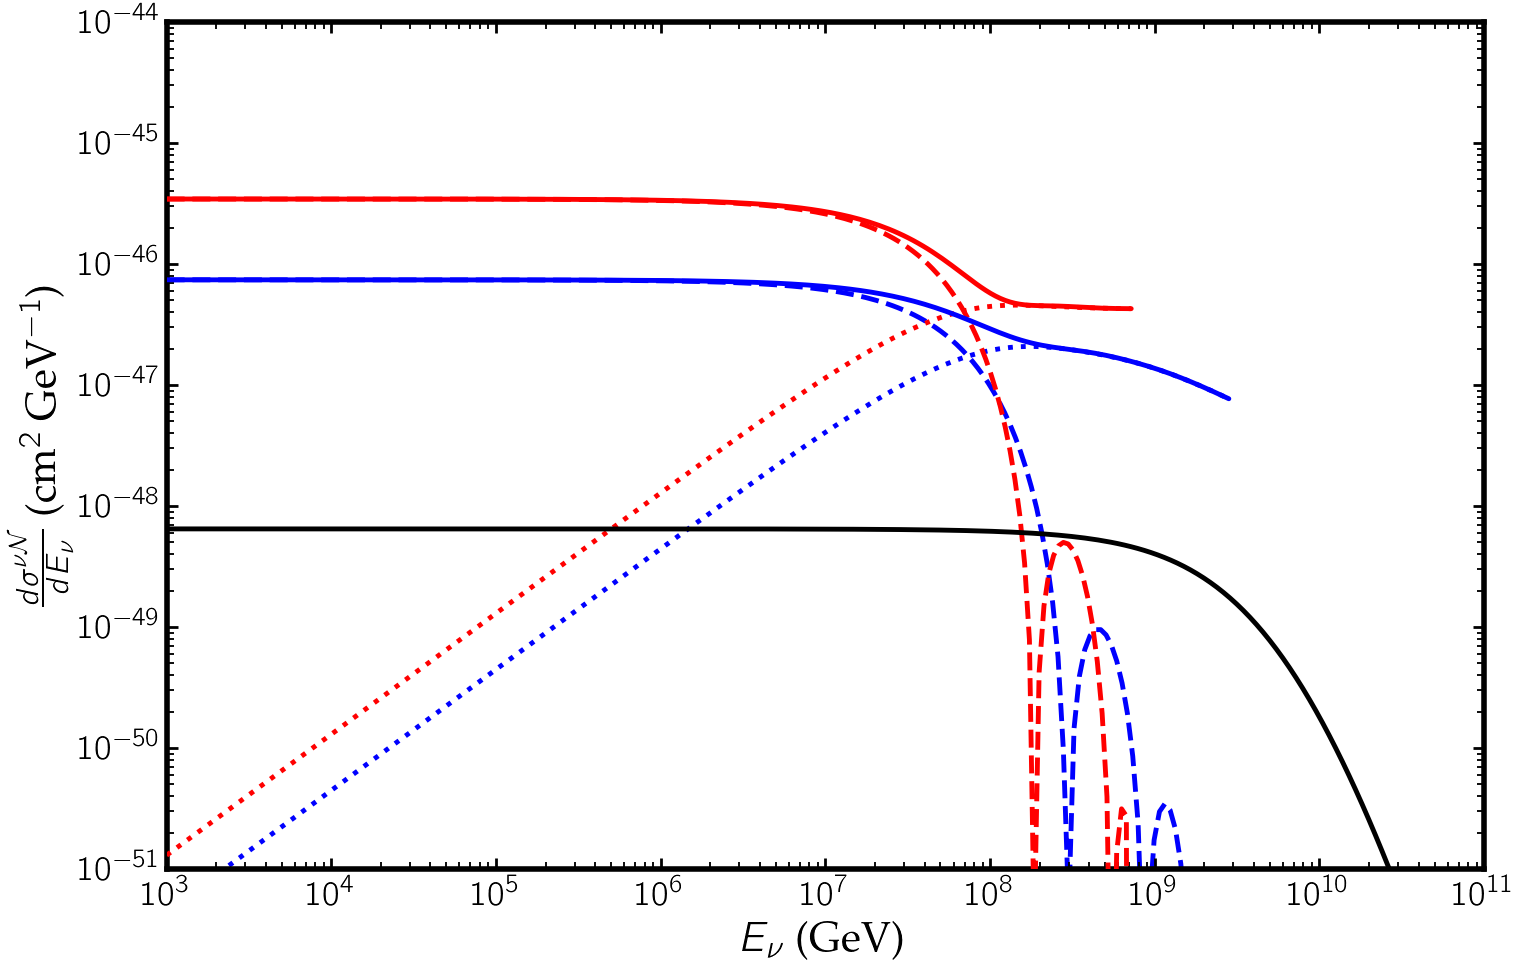

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D  # For custom legend
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for cross-section lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers
label_fs = 30       # Axis labels
legend_fs = 20      # Legend font size

# --- Style File Check ---
style_path = 'sty.mplstyle'
if os.path.exists(style_path):
    plt.style.use(style_path)
    print(f"Using style file: {style_path}")
else:
    print(f"Warning: Style file '{style_path}' not found. Using default styles.")

# --- Path Effects for Text ---
text_path_effects = [pe.withStroke(linewidth=3, foreground='white')]

# --- Function to Load and Plot Cross-Section Data ---
def plot_cross_section(ax, filepath, color, linestyle, label, zorder):
    try:
        dat = np.loadtxt(filepath, delimiter=',')
        if dat.ndim != 2 or dat.shape[1] < 2 or dat.shape[0] == 0:
            print(f"Error: Invalid data in {filepath}. Skipping.")
            return None, None
        x = dat[:, 0]  # Ev values
        y = dat[:, 1]  # Cross-section values
        if np.any(np.isfinite(y)):
            ax.plot(x, y, color=color, linestyle=linestyle, lw=base_line_lw, zorder=zorder, label=label)
            print(f"Plotted data for '{label}' from {filepath}.")
            return x, y
        else:
            print(f"Warning: No finite values to plot for '{label}' in {filepath}.")
            return None, None
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None

# --- Main Plotting Logic ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup Directories ---
base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(base_dir, '../data/')
plot_dir = os.path.join(base_dir, '../plots/')
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(plot_png_dir, exist_ok=True)

# --- File Paths ---
files = {
    'si_coh': os.path.join(data_dir, 'CrossSection-si-COH-11.csv'),
    'si_incoh': os.path.join(data_dir, 'CrossSection-si-INCOH-11.csv'),
    'fe_coh': os.path.join(data_dir, 'CrossSection-fe-COH-11.csv'),
    'fe_incoh': os.path.join(data_dir, 'CrossSection-fe-INCOH-11.csv'),
    'proton_es': os.path.join(data_dir, 'CrossSection-proton-11.csv')
}

# --- Plot Individual Cross-Sections ---
# Silicon (COH and INCOH)
si_coh_x, si_coh_y = plot_cross_section(ax, files['si_coh'], color='blue', linestyle='--', label='Si COH', zorder=1)
si_incoh_x, si_incoh_y = plot_cross_section(ax, files['si_incoh'], color='blue', linestyle=':', label='Si INCOH', zorder=2)

# Iron (COH and INCOH)
fe_coh_x, fe_coh_y = plot_cross_section(ax, files['fe_coh'], color='red', linestyle='--', label='Fe COH', zorder=3)
fe_incoh_x, fe_incoh_y = plot_cross_section(ax, files['fe_incoh'], color='red', linestyle=':', label='Fe INCOH', zorder=4)

# Proton (ES)
proton_x, proton_y = plot_cross_section(ax, files['proton_es'], color='black', linestyle='-', label='Proton ES', zorder=5)

# --- Plot COH + INCOH Sums ---
# Silicon COH + INCOH
if si_coh_x is not None and si_incoh_x is not None and np.allclose(si_coh_x, si_incoh_x, atol=1e-8, rtol=1e-5):
    si_sum_y = si_coh_y + si_incoh_y
    if np.any(np.isfinite(si_sum_y)):
        ax.plot(si_coh_x, si_sum_y, color='blue', linestyle='-', lw=base_line_lw, zorder=6, label='Si COH+INCOH')
        print("Plotted Si COH+INCOH sum.")
else:
    print("Warning: Could not compute Si COH+INCOH sum due to mismatched x-values or invalid data.")

# Iron COH + INCOH
if fe_coh_x is not None and fe_incoh_x is not None and np.allclose(fe_coh_x, fe_incoh_x, atol=1e-8, rtol=1e-5):
    fe_sum_y = fe_coh_y + fe_incoh_y
    if np.any(np.isfinite(fe_sum_y)):
        ax.plot(fe_coh_x, fe_sum_y, color='red', linestyle='-', lw=base_line_lw, zorder=7, label='Fe COH+INCOH')
        print("Plotted Fe COH+INCOH sum.")
else:
    print("Warning: Could not compute Fe COH+INCOH sum due to mismatched x-values or invalid data.")

# --- Axis Settings ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e3, 1e11])  # Adjusted based on Ev ranges
ax.set_ylim([1e-51, 1e-44])  # Adjust based on expected cross-section values
print(f"Note: Final Y-axis limits set to {ax.get_ylim()}.")

ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$\frac{d\sigma^{\nu \mathcal{N}}}{dE_{\nu}}$ (cm$^2$ GeV$^{-1}$)', fontsize=label_fs)  # Cross-section in cm^2
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=8)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=5)

# Thicken spines
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

# Set tick locators
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100))


# --- Save Plot ---
output_pdf = os.path.join(plot_dir, 'Differential cross section.pdf')
plt.savefig(output_pdf, transparent=False, bbox_inches='tight')
print(f"Saved plot to {output_pdf}")

# --- Display Plot ---
plt.show()

Using style file: sty.mplstyle
Plotted data for 'Si COH' from /Users/zjj/Desktop/CnuB/code/../data/totalcrosssection-si-coh.csv.
Plotted data for 'Si INCOH' from /Users/zjj/Desktop/CnuB/code/../data/totalcrosssection-si-incoh.csv.
Plotted data for 'Fe COH' from /Users/zjj/Desktop/CnuB/code/../data/totalcrosssection-fe-coh.csv.
Plotted data for 'Fe INCOH' from /Users/zjj/Desktop/CnuB/code/../data/totalcrosssection-fe-incoh.csv.
Plotted data for 'Proton ES' from /Users/zjj/Desktop/CnuB/code/../data/totalcrosssection-p.csv.
Plotted Si COH+INCOH sum.
Plotted Fe COH+INCOH sum.
Note: Final Y-axis limits set to (1e-44, 1e-35).
Saved plot to /Users/zjj/Desktop/CnuB/code/../plots/total cross section.pdf


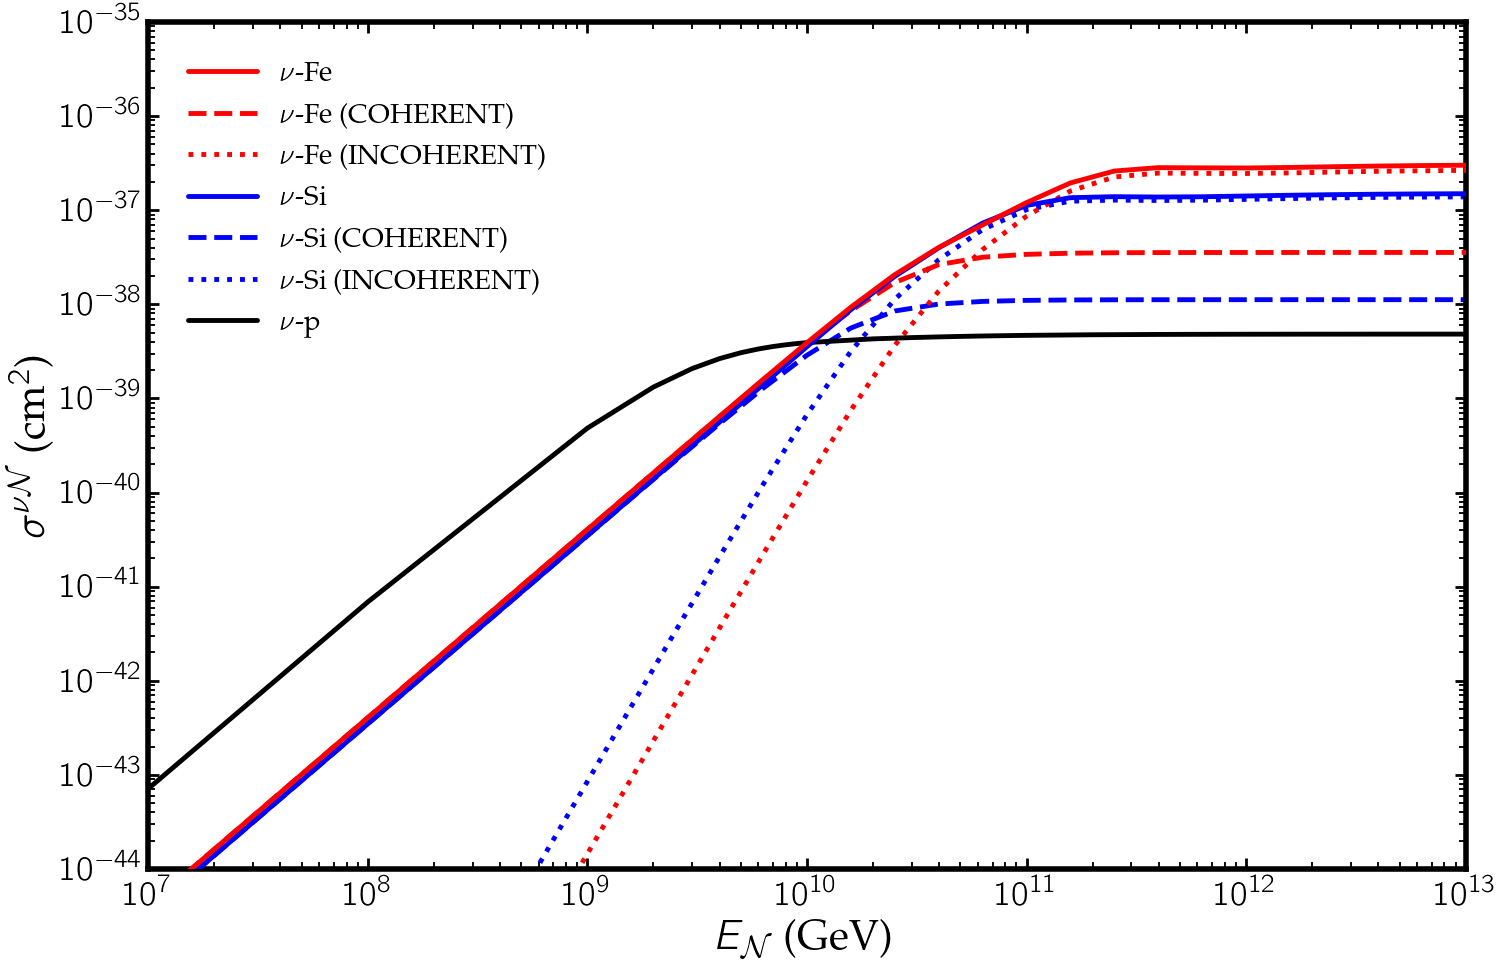

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D  # For custom legend
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for cross-section lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers
label_fs = 30       # Axis labels
legend_fs = 20      # Legend font size

# --- Style File Check ---
style_path = 'sty.mplstyle'
if os.path.exists(style_path):
    plt.style.use(style_path)
    print(f"Using style file: {style_path}")
else:
    print(f"Warning: Style file '{style_path}' not found. Using default styles.")

# --- Path Effects for Text ---
text_path_effects = [pe.withStroke(linewidth=3, foreground='white')]

# --- Function to Load and Plot Cross-Section Data ---
def plot_cross_section(ax, filepath, color, linestyle, label, zorder):
    try:
        dat = np.loadtxt(filepath, delimiter=',')
        if dat.ndim != 2 or dat.shape[1] < 2 or dat.shape[0] == 0:
            print(f"Error: Invalid data in {filepath}. Skipping.")
            return None, None
        x = dat[:, 0]  # En values
        y = dat[:, 1]  # Cross-section values
        if np.any(np.isfinite(y)):
            ax.plot(x, y, color=color, linestyle=linestyle, lw=base_line_lw, zorder=zorder, label=label)
            print(f"Plotted data for '{label}' from {filepath}.")
            return x, y
        else:
            print(f"Warning: No finite values to plot for '{label}' in {filepath}.")
            return None, None
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None

# --- Main Plotting Logic ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup Directories ---
base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(base_dir, '../data/')
plot_dir = os.path.join(base_dir, '../plots/')
os.makedirs(plot_dir, exist_ok=True)

# --- File Paths ---
files = {
    'si_coh': os.path.join(data_dir, 'totalcrosssection-si-coh.csv'),
    'si_incoh': os.path.join(data_dir, 'totalcrosssection-si-incoh.csv'),
    'fe_coh': os.path.join(data_dir, 'totalcrosssection-fe-coh.csv'),
    'fe_incoh': os.path.join(data_dir, 'totalcrosssection-fe-incoh.csv'),
    'proton_es': os.path.join(data_dir, 'totalcrosssection-p.csv')
}

# --- Plot Individual Cross-Sections ---
# Silicon (COH and INCOH)
si_coh_x, si_coh_y = plot_cross_section(ax, files['si_coh'], color='blue', linestyle='--', label='Si COH', zorder=1)
si_incoh_x, si_incoh_y = plot_cross_section(ax, files['si_incoh'], color='blue', linestyle=':', label='Si INCOH', zorder=2)

# Iron (COH and INCOH)
fe_coh_x, fe_coh_y = plot_cross_section(ax, files['fe_coh'], color='red', linestyle='--', label='Fe COH', zorder=3)
fe_incoh_x, fe_incoh_y = plot_cross_section(ax, files['fe_incoh'], color='red', linestyle=':', label='Fe INCOH', zorder=4)

# Proton (ES)
proton_x, proton_y = plot_cross_section(ax, files['proton_es'], color='black', linestyle='-', label='Proton ES', zorder=5)

# --- Plot COH + INCOH Sums ---
# Silicon COH + INCOH
if si_coh_x is not None and si_incoh_x is not None and np.allclose(si_coh_x, si_incoh_x, atol=1e-8, rtol=1e-5):
    si_sum_y = si_coh_y + si_incoh_y
    if np.any(np.isfinite(si_sum_y)):
        ax.plot(si_coh_x, si_sum_y, color='blue', linestyle='-', lw=base_line_lw, zorder=6, label='Si COH+INCOH')
        print("Plotted Si COH+INCOH sum.")
else:
    print("Warning: Could not compute Si COH+INCOH sum due to mismatched x-values or invalid data.")

# Iron COH + INCOH
if fe_coh_x is not None and fe_incoh_x is not None and np.allclose(fe_coh_x, fe_incoh_x, atol=1e-8, rtol=1e-5):
    fe_sum_y = fe_coh_y + fe_incoh_y
    if np.any(np.isfinite(fe_sum_y)):
        ax.plot(fe_coh_x, fe_sum_y, color='red', linestyle='-', lw=base_line_lw, zorder=7, label='Fe COH+INCOH')
        print("Plotted Fe COH+INCOH sum.")
else:
    print("Warning: Could not compute Fe COH+INCOH sum due to mismatched x-values or invalid data.")

# --- Axis Settings ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e7, 1e13])  # Adjusted based on En ranges
ax.set_ylim([1e-44, 1e-35])  # Adjust based on expected cross-section values
print(f"Note: Final Y-axis limits set to {ax.get_ylim()}.")
ax.set_xlabel(r'$E_\mathcal{N}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$\sigma^{\nu \mathcal{N}}$ (cm$^2$)', fontsize=label_fs) 
 # Cross-section in cm^2
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=8)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=5)

# Thicken spines
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

# Set tick locators
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100))

# --- Create Custom Legend ---
legend_elements = [
    Line2D([0], [0], color='red', lw=base_line_lw, linestyle='-', label=r'$\nu$-Fe'),
    Line2D([0], [0], color='red', lw=base_line_lw, linestyle='--', label=r'$\nu$-Fe  (COHERENT)'),
    Line2D([0], [0], color='red', lw=base_line_lw, linestyle=':', label=r'$\nu$-Fe  (INCOHERENT)'),
    Line2D([0], [0], color='blue', lw=base_line_lw, linestyle='-', label=r'$\nu$-Si'),
    Line2D([0], [0], color='blue', lw=base_line_lw, linestyle='--', label=r'$\nu$-Si  (COHERENT)'),
    Line2D([0], [0], color='blue', lw=base_line_lw, linestyle=':', label=r'$\nu$-Si  (INCOHERENT)'),
    Line2D([0], [0], color='black', lw=base_line_lw, linestyle='-', label=r'$\nu$-p')
]

# Adjusted legend with precise coordinates
ax.legend(
    handles=legend_elements,
    loc='upper right',
    fontsize=legend_fs,
    frameon=False,
    handlelength=2.5,
    handletextpad=0.8,
    labelspacing=0.5,
    borderpad=0.3,
    bbox_to_anchor=(0.32, 0.98)  # Slightly offset from upper-right corner
)

# --- Save Plot ---
output_pdf = os.path.join(plot_dir, 'total cross section.pdf')
plt.savefig(output_pdf, transparent=False, bbox_inches='tight')
print(f"Saved plot to {output_pdf}")

# --- Display Plot ---
plt.show()

--- Applying y-axis scaling factor for all-flavor flux: 3.0 ---
--- Scaling both data point centers AND error lengths for log-scale visual consistency ---
Using style file: sty.mplstyle
Using Overdensity Factor: 1.0e+08
Data directory resolved to: /Users/zjj/Desktop/CnuB/code/../data/
Plot directory resolved to: /Users/zjj/Desktop/CnuB/code/../plots/
Processing 9 files for prefix 'QSO-100'...
Plotted scaled summed and transformed data for 'QSO-100'.
Processing 9 files for prefix 'QSO-50'...
Plotted scaled summed and transformed data for 'QSO-50'.
Processing 9 files for prefix 'QSO-10'...
Plotted scaled summed and transformed data for 'QSO-10'.
Note: Final Y-axis limits set to (1e-10, 1e-06) (scaled).
Saved scaled plot to /Users/zjj/Desktop/CnuB/code/../plots/all-flux-QSO.pdf


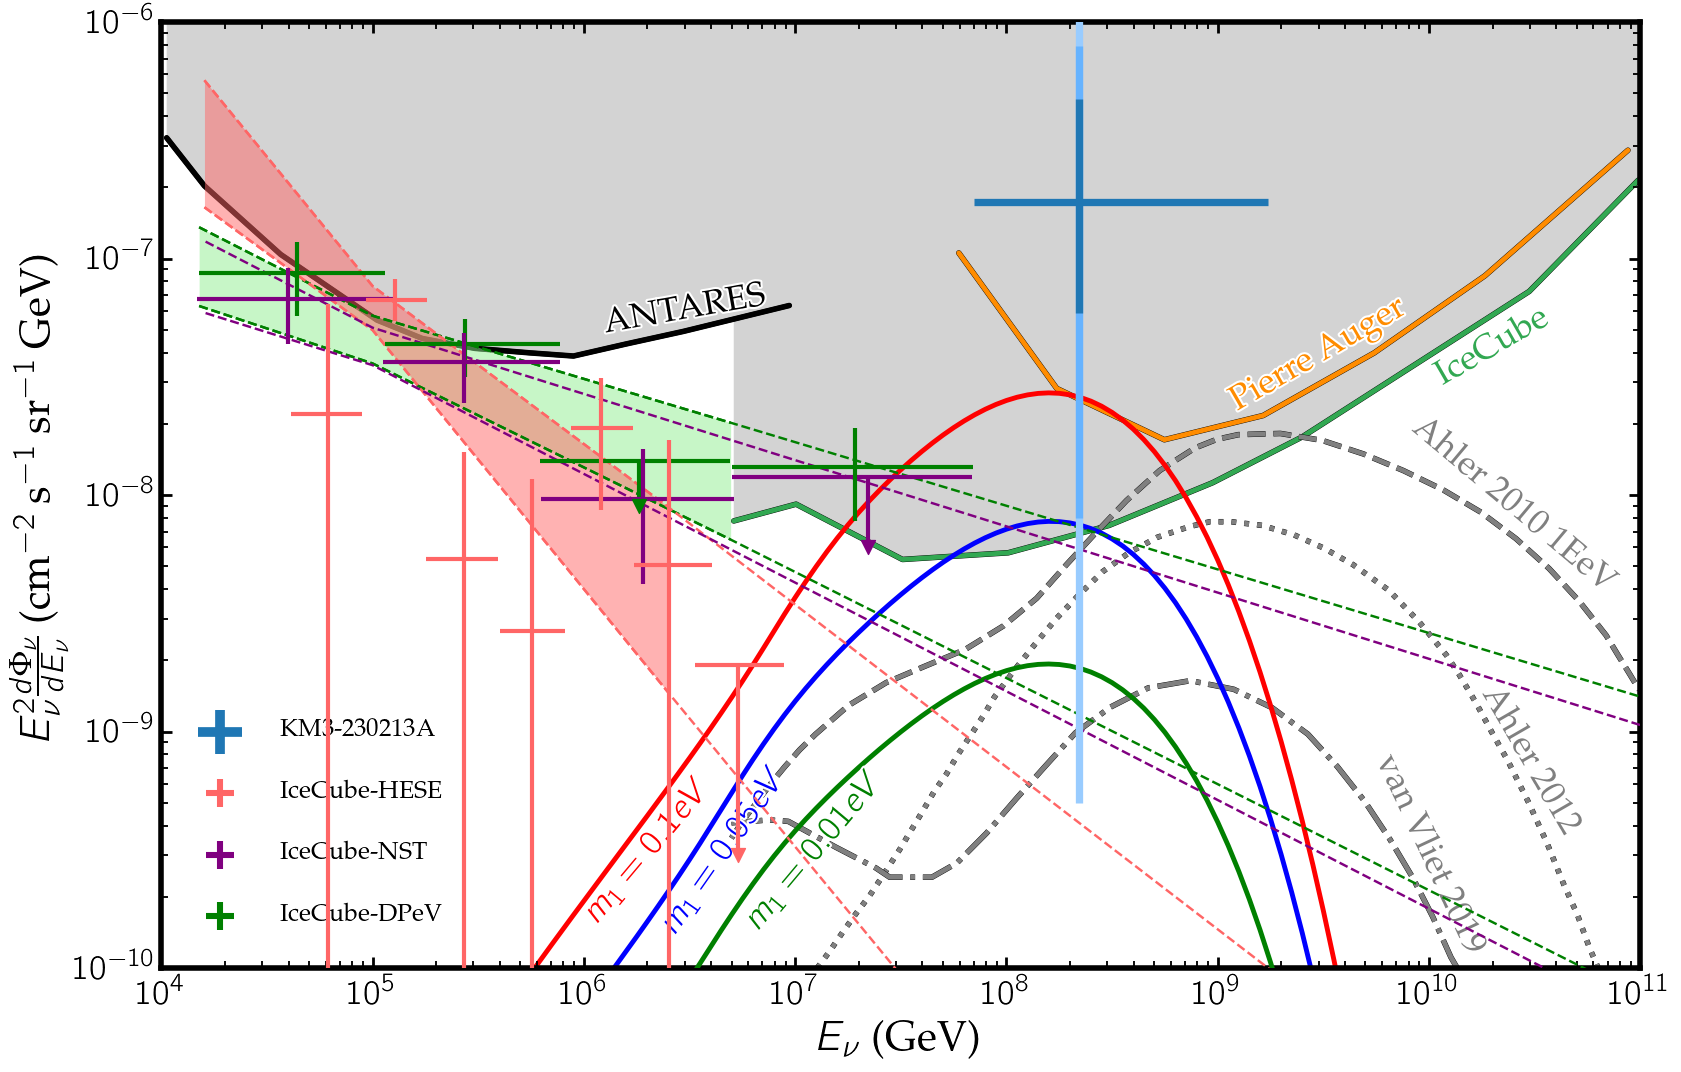

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D  # For custom legend
from matplotlib.patches import Rectangle # For filled box legend entries
import glob
import os

# --- Configuration ---
base_line_lw = 3.5
thin_line_lw = base_line_lw / 2
km3net_lw = base_line_lw * 1.5
spine_lw = 4.0
tick_fs = 25
label_fs = 30
inline_text_fs = 25
legend_fs = 18
# --- Legend Marker Specific Configurations ---
marker_size = 20    # Size for '+' markers
cross_lw = km3net_lw / 1.2 # Linewidth for '+' markers
box_size = 0.04     # Size of the filled box markers
box_lw = 1.5 * 3    # Linewidth for box markers (Increased x3)
line_lw = base_line_lw # Linewidth for line markers (Not used anymore for Auger)

# --- Scaling Factor for All-Flavor Flux ---
scaling_factor = 3.0 # Multiply y-values by this factor
print(f"--- Applying y-axis scaling factor for all-flavor flux: {scaling_factor:.1f} ---")
print("--- Scaling both data point centers AND error lengths for log-scale visual consistency ---")

# --- Style File Check ---
style_path = 'sty.mplstyle'
if os.path.exists(style_path):
    plt.style.use(style_path)
    print(f"Using style file: {style_path}")
else:
    print(f"Warning: Style file '{style_path}' not found. Using default Matplotlib styles.")

# --- Path Effects for Text ---
text_path_effects = [pe.withStroke(linewidth=3, foreground='white')]

# --- PlotConstraint Function (Scaled) ---
def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1e6, # Increase y2 substantially
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                   label_text='', label_pos=(1e7, 1e-8), rotation=0, text_color=None,
                   label='', textalpha=1, linestyle='-'):
    global scaling_factor
    try:
        dat = np.loadtxt(filepath, delimiter=',')
        dat[:, 1] *= scaling_factor # Scale Y data
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None

    line, = plt.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw,
                     path_effects=path_effects, alpha=edgealpha, zorder=zorder)

    if filled:
        actual_fill_zorder = min(zorder - 0.1, fill_zorder)
        # Also scale the fill boundary if it's not effectively infinity
        fill_y2 = y2 * scaling_factor if y2 < 1e5 else y2 # Avoid scaling if y2 is already huge
        plt.fill_between(dat[:, 0], dat[:, 1], y2=fill_y2, color=facecolor, alpha=facealpha, zorder=actual_fill_zorder, lw=0)

    if label_text:
        text_c = text_color if text_color else edgecolor
        scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
        ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs,
                color=text_c, rotation=rotation, path_effects=text_path_effects,
                clip_on=True, alpha=textalpha, rotation_mode='anchor', ha='center', va='center')
    return line

# --- plot_qso_sum Function (Scaled) ---
def plot_qso_sum(ax, data_dir, prefix, color, linestyle,
                 label_text='', label_pos=(1e9, 1e-10), rotation=-45,
                 overdensity_factor=1.0, lw=base_line_lw, zorder=1):
    global scaling_factor
    search_pattern = os.path.join(data_dir, f"{prefix}-*.csv")
    file_list = sorted(glob.glob(search_pattern))
    if not file_list: print(f"Warning: No files found for prefix '{prefix}' with pattern '{search_pattern}'"); return
    print(f"Processing {len(file_list)} files for prefix '{prefix}'...")
    sum_y, base_x, first_file = None, None, True
    for filepath in file_list:
        try:
            dat = np.loadtxt(filepath, delimiter=',')
            if dat.ndim != 2 or dat.shape[1] < 2 or dat.shape[0] == 0: continue
            current_x, current_y = dat[:, 0], dat[:, 1]
            if first_file: base_x, sum_y, first_file = current_x, current_y.copy(), False
            else:
                if len(base_x) != len(current_x) or not np.allclose(base_x, current_x, atol=1e-8, rtol=1e-5):
                    print(f"Error: X-values mismatch in {os.path.basename(filepath)} for '{prefix}'. Skipping."); continue
                sum_y += current_y
        except Exception as e: print(f"Error processing {filepath}: {e}"); continue
    if sum_y is None or base_x is None: print(f"Warning: No sum for '{prefix}'."); return

    transformed_y = sum_y * (base_x ** 2) * overdensity_factor * scaling_factor # Scale Y data

    if np.any(np.isfinite(transformed_y)):
        ax.plot(base_x, transformed_y, color=color, linestyle=linestyle, lw=lw, zorder=zorder)
        print(f"Plotted scaled summed and transformed data for '{prefix}'.")
        if label_text:
            scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
            ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs, color=color, rotation=rotation,
                    path_effects=text_path_effects, clip_on=True, alpha=1.0, rotation_mode='anchor', ha='center', va='center')
    else: print(f"Warning: No finite values to plot for prefix '{prefix}'.")


# --- Main Plotting Logic ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

overdensity_factor = 1e8
print(f"Using Overdensity Factor: {overdensity_factor:.1e}")
base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_dir_rel, plot_dir_rel = '../data/', '../plots/'
data_dir, plot_dir = os.path.join(base_dir, data_dir_rel), os.path.join(base_dir, plot_dir_rel)
plot_png_dir = os.path.join(plot_dir, 'plots_png/')
os.makedirs(plot_dir, exist_ok=True); os.makedirs(plot_png_dir, exist_ok=True)
print(f"Data directory resolved to: {data_dir}")
print(f"Plot directory resolved to: {plot_dir}")

# --- Define Colors Consistently ---
icecube_color = '#32a852'
auger_color = '#FF8C00'
antares_color = 'black'
fill_color = 'lightgray'

# --- Plot IceCube, Auger, ANTARES, and New Lines (Scaled inside PlotConstraint) ---
icecube_label_pos, auger_label_pos, ANTARES95_label_pos = (2e10, 1.4e-8), (3e9, 1.3e-8), (3e6, 2e-8)
ahler2010_label_pos, ahler2012_label_pos, vliet2019_label_pos = (2.5e10, 3e-9), (3e10, 2.5e-10), (1e10, 1e-10)  # Individual positions to avoid overlap
icecube_rotation, auger_rotation, ANTARES95_rotation = 30, 30, 10
PlotConstraint(ax, os.path.join(data_dir, 'IceCube-12.6.csv'), filled=True, label_text='IceCube', label_pos=icecube_label_pos, rotation=icecube_rotation, edgecolor=icecube_color, facecolor=fill_color, zorder=0)
PlotConstraint(ax, os.path.join(data_dir, 'Auger.csv'), filled=False, label_text='Pierre Auger', text_color='#FF8C00', label_pos=auger_label_pos, rotation=auger_rotation, edgecolor=auger_color, zorder=0.5)
PlotConstraint(ax, os.path.join(data_dir, 'ANTARES95.csv'), filled=True, label_text='ANTARES', label_pos=ANTARES95_label_pos, rotation=ANTARES95_rotation, edgecolor=antares_color, facecolor=fill_color, zorder=0)
# Add new lines for Ahler 2010, Ahler 2012, and Vliet 2019 with individual label positions
PlotConstraint(ax, os.path.join(data_dir, 'ahler2010.csv'), filled=False, label_text='Ahler 2010 1EeV', label_pos=ahler2010_label_pos, rotation=-40, edgecolor='gray', linestyle='--', zorder=0)  # Dashed line
PlotConstraint(ax, os.path.join(data_dir, 'ahler2012.csv'), filled=False, label_text='Ahler 2012', label_pos=ahler2012_label_pos, rotation=-60, edgecolor='gray', linestyle=':', zorder=0)  # Dotted line
PlotConstraint(ax, os.path.join(data_dir, 'vliet2019.csv'), filled=False, label_text='van Vliet 2019', label_pos=vliet2019_label_pos, rotation=-65, edgecolor='gray', linestyle='-.', zorder=0)  # Dash-dot line

# --- QSO Definitions & Plotting (Scaled inside plot_qso_sum) ---
qso_prefixes = ['QSO-100', 'QSO-50', 'QSO-10']
qso_colors = ['red', 'blue', 'green']
qso_linestyles = ['-', '-', '-']
qso_label_texts = {'QSO-100': r'$m_1=0.1eV$', 'QSO-50': r'$m_1=0.05eV$', 'QSO-10': r'$m_1=0.01eV$'}
qso_label_params = {'QSO-100': (1.95e6, 1e-10, +50), 'QSO-50': (4.5e6, 1e-10, +55), 'QSO-10': (1.2e7, 1e-10, +50)}
for i, prefix in enumerate(qso_prefixes):
    params = qso_label_params.get(prefix, (1e9, 1e-11, -45))
    label_txt = qso_label_texts.get(prefix, prefix)
    plot_qso_sum(ax, data_dir, prefix, color=qso_colors[i % len(qso_colors)], linestyle=qso_linestyles[i % len(qso_linestyles)], label_text=label_txt, label_pos=(params[0], params[1]), rotation=params[2], overdensity_factor=overdensity_factor, zorder=i + 1)

# --- Plot DPeV Fill (Scaled) ---
try:
    dpev_upper = np.loadtxt(os.path.join(data_dir, 'DpeV-up.csv'), delimiter=','); dpev_lower = np.loadtxt(os.path.join(data_dir, 'DpeV-down.csv'), delimiter=',')
    dpev_upper[:, 1] *= scaling_factor # Scale Y data
    dpev_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(dpev_upper[:, 0], dpev_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(dpev_upper[:, 0], dpev_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(dpev_lower[:, 0], dpev_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(dpev_upper[:, 0], dpev_lower[:, 1], dpev_upper[:, 1], color='lightgreen', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: DPeV x values misaligned.")
except Exception as e: print(f"Error processing DPeV files: {e}")

# --- Plot HEST Fill (Scaled) ---
try:
    hest_upper = np.loadtxt(os.path.join(data_dir, 'HEST-up.csv'), delimiter=','); hest_lower = np.loadtxt(os.path.join(data_dir, 'HEST-down.csv'), delimiter=',')
    hest_upper[:, 1] *= scaling_factor # Scale Y data
    hest_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(hest_upper[:, 0], hest_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(hest_upper[:, 0], hest_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(hest_lower[:, 0], hest_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(hest_upper[:, 0], hest_lower[:, 1], hest_upper[:, 1], color='#FF6666', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: HEST x values misaligned.")
except Exception as e: print(f"Error processing HEST files: {e}")

# --- Plot Dashed Lines (DPeVall, HESTall, NSTall) (Scaled) ---
try:
    dpevall_upper = np.loadtxt(os.path.join(data_dir, 'DPeVall-up.csv'), delimiter=','); dpevall_lower = np.loadtxt(os.path.join(data_dir, 'DPeVall-down.csv'), delimiter=',')
    hestall_upper = np.loadtxt(os.path.join(data_dir, 'HESTall-up.csv'), delimiter=','); hestall_lower = np.loadtxt(os.path.join(data_dir, 'HESTall-down.csv'), delimiter=',')
    nstall_upper = np.loadtxt(os.path.join(data_dir, 'NSTall-up.csv'), delimiter=','); nstall_lower = np.loadtxt(os.path.join(data_dir, 'NSTall-down.csv'), delimiter=',')

    dpevall_upper[:, 1] *= scaling_factor; dpevall_lower[:, 1] *= scaling_factor # Scale Y
    hestall_upper[:, 1] *= scaling_factor; hestall_lower[:, 1] *= scaling_factor # Scale Y
    nstall_upper[:, 1] *= scaling_factor; nstall_lower[:, 1] *= scaling_factor # Scale Y

    ax.plot(dpevall_upper[:, 0], dpevall_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(dpevall_lower[:, 0], dpevall_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(hestall_upper[:, 0], hestall_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(hestall_lower[:, 0], hestall_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(nstall_upper[:, 0], nstall_upper[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(nstall_lower[:, 0], nstall_lower[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3)
except Exception as e: print(f"Error processing dashed line files: {e}")


# --- Add Special Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
x_center_green_orig, y_center_green_orig, y_lower_green_orig = 1.82e6, 4.63e-9, 3e-9
x_err_green = [[1.2e6], [3.1e6]] # X error unchanged
y_center_green_scaled = y_center_green_orig * scaling_factor # Scale center y
y_lower_green_scaled = y_lower_green_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_green_scaled - y_lower_green_scaled # Calculate scaled error length
y_err_green_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_green_orig, y_center_green_scaled, xerr=x_err_green, yerr=y_err_green_scaled, fmt=' ', color='green', ecolor='green', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_green_orig, y_lower_green_scaled, color='green', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_pink_orig, y_center_pink_orig, y_lower_pink_orig = 5.36e6, 6.36e-10, 1e-10
x_err_pink = [[2e6], [3.5e6]] # X error unchanged
y_center_pink_scaled = y_center_pink_orig * scaling_factor # Scale center y
y_lower_pink_scaled = y_lower_pink_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_pink_scaled - y_lower_pink_scaled # Calculate scaled error length
y_err_pink_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_pink_orig, y_center_pink_scaled, xerr=x_err_pink, yerr=y_err_pink_scaled, fmt=' ', color='#FF6666', ecolor='#FF6666', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_pink_orig, y_lower_pink_scaled, color='#FF6666', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_purple_orig, y_center_purple_orig, y_lower_purple_orig = 2.2e7, 3.98e-9, 2e-9
x_err_purple = [[1.7e7], [4.7e7]] # X error unchanged
y_center_purple_scaled = y_center_purple_orig * scaling_factor # Scale center y
y_lower_purple_scaled = y_lower_purple_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_purple_scaled - y_lower_purple_scaled # Calculate scaled error length
y_err_purple_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_purple_orig, y_center_purple_scaled, xerr=x_err_purple, yerr=y_err_purple_scaled, fmt=' ', color='purple', ecolor='purple', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_purple_orig, y_lower_purple_scaled, color='purple', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos


# --- Add Normal Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
error_bars = {
    'green': {'centers': [(4.4e4, 2.9e-8), (2.75e5, 1.45e-8), (1.92e7, 4.38e-9)], 'x_errs': [(2.9e4, 7e4), (1.6e5, 5e5), (1.42e7, 5e7)], 'y_errs': [(1e-8, 1e-8), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    'purple': {'centers': [(3.97e4, 2.25e-8), (2.72e5, 1.22e-8), (1.91e6, 3.2e-9)], 'x_errs': [(2.5e4, 8.6e4), (1.6e5, 5e5), (1.28e6, 3.2e6)], 'y_errs': [(8e-9, 8e-9), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    '#FF6666': {'centers': [(6.13e4, 7.33e-9), (1.28e5, 2.22e-8), (2.72e5, 1.78e-9), (5.7e5, 8.87e-10), (1.2e6, 6.38e-9), (2.53e6, 1.68e-9)], 'x_errs': [(2e4, 2.8e4), (3.5e4, 5.2e4), (9.3e4, 1.2e5), (1.7e5, 2.4e5), (3.3e5, 5e5), (8e5, 1.5e6)], 'y_errs': [(4e-8, 1.4e-8), (4e-9, 5e-9), (2e-8, 3.3e-9), (4e-8, 3e-9), (3.5e-9, 4e-9), (3e-8, 4e-9)]}
}
for color, data in error_bars.items():
    for (x, y_orig), (xl, xr), (yl_orig, yu_orig) in zip(data['centers'], data['x_errs'], data['y_errs']):
        # --- SCALING Center Point Y ---
        y_scaled = y_orig * scaling_factor
        # --- SCALING Error Lengths Y ---
        yl_scaled = yl_orig * scaling_factor
        yu_scaled = yu_orig * scaling_factor
        # --- Use scaled y, scaled yl, scaled yu ---
        ax.errorbar(x, y_scaled, xerr=[[xl], [xr]], yerr=[[yl_scaled], [yu_scaled]], fmt=' ', color=color, ecolor=color, capsize=0, zorder=10, label='_nolegend_')


# --- Add KM3NeT Error Bar (SCALED CENTER AND SCALED ERROR LENGTHS for log vis) ---
x_center_km3net_orig, y_center_km3net_orig = 2.2e8, 5.8e-8
x_err_km3net = [[1.5e8], [1.5e9]] # X error unchanged

# --- Scale center y ---
y_center_km3net_scaled = y_center_km3net_orig * scaling_factor

# --- Scale Y error lengths ---
y_err_1s_orig = [[1.15e-7], [3e-7]]
y_err_2s_orig = [[1.66e-7], [6.2e-7]]
y_err_3s_orig = [[1.735e-7], [9.1e-7]]

colors_km3net = ['#1f77b4', '#66b3ff', '#99ccff']

# --- Plot using scaled center and ORIGINAL error lengths ---
# The layering approach works correctly when lengths are scaled proportionally
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_1s_orig, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_2s_orig, fmt=' ', color=colors_km3net[1], ecolor=colors_km3net[1], lw=km3net_lw, capsize=0, zorder=11)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_3s_orig, fmt=' ', color=colors_km3net[2], ecolor=colors_km3net[2], lw=km3net_lw, capsize=0, zorder=10)
# Plot X error bar relative to scaled center
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, xerr=x_err_km3net, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12, label='_nolegend_')

# --- Axis Settings ---
ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xlim([1e4, 1e11])
# --- SCALED Y-LIMITS ---
original_ylim = [1e-10, 1e-6]
scaled_ylim = [lim * 1 for lim in original_ylim]
ax.set_ylim(scaled_ylim)
# --- END SCALED Y-LIMITS ---
print(f"Note: Final Y-axis limits set to {ax.get_ylim()} (scaled).")
ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$E_{\nu}^{2} \frac{d\Phi_{\nu}}{dE_{\nu}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV)', fontsize=label_fs)
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=8)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=5)
for spine in ax.spines.values(): spine.set_linewidth(spine_lw)
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj); ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100))

# --- Add Custom Annotations (Legend) outside the plot (UNCHANGED) ---
legend_x_start = 0.08
marker_x_offset = -0.04
legend_y_start = 0.25
legend_y_step = 0.065
current_y = legend_y_start
# ... (rest of legend code is unchanged) ...
# 1. KM3NeT (Blue Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color=colors_km3net[0], ms=marker_size*1.6, mew=cross_lw*1.6, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "KM3-230213A", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 2. IceCube HEST (Pink Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='#FF6666', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 3. IceCube NST (Purple Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='purple', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-NST", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 4. IceCube DPeV (Green Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='green', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# # 5. DPeV (Light Green Box - Thicker Border)
# nst_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='lightgreen', alpha=0.7, edgecolor='darkgreen', lw=box_lw)
# ax.add_patch(nst_box)
# ax.text(legend_x_start, current_y, "DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step
# # 6. HEST (Pink Box - Thicker Border)
# hest_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='#FF6666', alpha=0.7, edgecolor='#FF6666', lw=box_lw)
# ax.add_patch(hest_box)
# ax.text(legend_x_start, current_y, "HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step


# --- Adjust Layout and Save Plot ---
plt.subplots_adjust(left=0.09, right=0.96, top=0.96, bottom=0.1)

output_pdf = os.path.join(plot_dir, 'all-flux-QSO.pdf')
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

try:
    plt.savefig(output_pdf, transparent=False)
    print(f"Saved scaled plot to {output_pdf}")
except Exception as e:
     print(f"Saving without bbox_inches='tight' failed: {e}. Trying with bbox_inches='tight'.")
     plt.savefig(output_pdf, transparent=False, bbox_inches='tight')
     print(f"Saved scaled plot to {output_pdf}")

# --- Display Plot ---
plt.show()

--- Applying y-axis scaling factor for all-flavor flux: 3.0 ---
--- Scaling both data point centers AND error lengths for log-scale visual consistency ---
Using style file: sty.mplstyle
Using Overdensity Factor: 1.0e+08
Data directory resolved to: /Users/zjj/Desktop/CnuB/code/../data/
Plot directory resolved to: /Users/zjj/Desktop/CnuB/code/../plots/
Processing 9 files for prefix 'GRB-100'...
Plotted scaled summed and transformed data for 'GRB-100'.
Processing 9 files for prefix 'GRB-50'...
Plotted scaled summed and transformed data for 'GRB-50'.
Processing 9 files for prefix 'GRB-10'...
Plotted scaled summed and transformed data for 'GRB-10'.
Note: Final Y-axis limits set to (1e-10, 1e-06) (scaled).
Saved scaled plot to /Users/zjj/Desktop/CnuB/code/../plots/all-flux-GRB.pdf


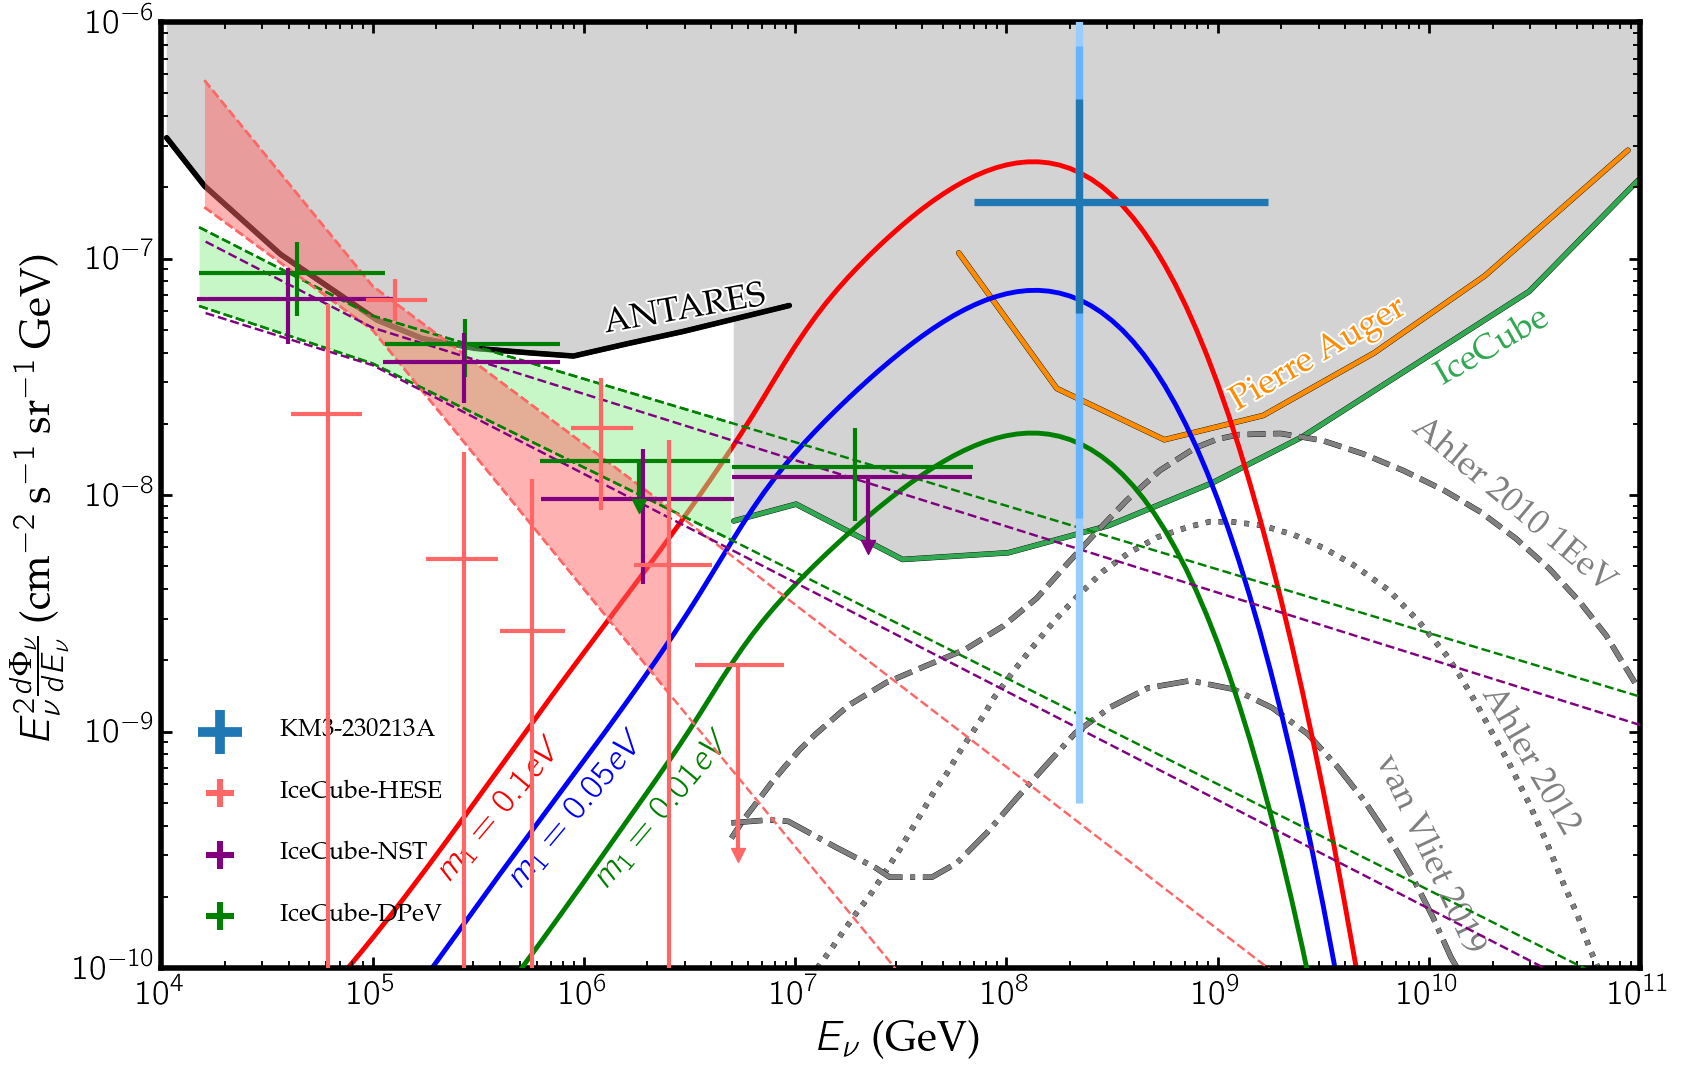

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D  # For custom legend
from matplotlib.patches import Rectangle # For filled box legend entries
import glob
import os

# --- Configuration ---
base_line_lw = 3.5
thin_line_lw = base_line_lw / 2
km3net_lw = base_line_lw * 1.5
spine_lw = 4.0
tick_fs = 25
label_fs = 30
inline_text_fs = 25
legend_fs = 18
# --- Legend Marker Specific Configurations ---
marker_size = 20    # Size for '+' markers
cross_lw = km3net_lw / 1.2 # Linewidth for '+' markers
box_size = 0.04     # Size of the filled box markers
box_lw = 1.5 * 3    # Linewidth for box markers (Increased x3)
line_lw = base_line_lw # Linewidth for line markers (Not used anymore for Auger)

# --- Scaling Factor for All-Flavor Flux ---
scaling_factor = 3.0 # Multiply y-values by this factor
print(f"--- Applying y-axis scaling factor for all-flavor flux: {scaling_factor:.1f} ---")
print("--- Scaling both data point centers AND error lengths for log-scale visual consistency ---")

# --- Style File Check ---
style_path = 'sty.mplstyle'
if os.path.exists(style_path):
    plt.style.use(style_path)
    print(f"Using style file: {style_path}")
else:
    print(f"Warning: Style file '{style_path}' not found. Using default Matplotlib styles.")

# --- Path Effects for Text ---
text_path_effects = [pe.withStroke(linewidth=3, foreground='white')]

# --- PlotConstraint Function (Scaled) ---
def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1e6, # Increase y2 substantially
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                   label_text='', label_pos=(1e7, 1e-8), rotation=0, text_color=None,
                   label='', textalpha=1, linestyle='-'):
    global scaling_factor
    try:
        dat = np.loadtxt(filepath, delimiter=',')
        dat[:, 1] *= scaling_factor # Scale Y data
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None

    line, = plt.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw,
                     path_effects=path_effects, alpha=edgealpha, zorder=zorder)

    if filled:
        actual_fill_zorder = min(zorder - 0.1, fill_zorder)
        # Also scale the fill boundary if it's not effectively infinity
        fill_y2 = y2 * scaling_factor if y2 < 1e5 else y2 # Avoid scaling if y2 is already huge
        plt.fill_between(dat[:, 0], dat[:, 1], y2=fill_y2, color=facecolor, alpha=facealpha, zorder=actual_fill_zorder, lw=0)

    if label_text:
        text_c = text_color if text_color else edgecolor
        scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
        ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs,
                color=text_c, rotation=rotation, path_effects=text_path_effects,
                clip_on=True, alpha=textalpha, rotation_mode='anchor', ha='center', va='center')
    return line

# --- plot_grb_sum Function (Scaled) ---
def plot_grb_sum(ax, data_dir, prefix, color, linestyle,
                 label_text='', label_pos=(1e9, 1e-10), rotation=-45,
                 overdensity_factor=1.0, lw=base_line_lw, zorder=1):
    global scaling_factor
    search_pattern = os.path.join(data_dir, f"{prefix}-*.csv")
    file_list = sorted(glob.glob(search_pattern))
    if not file_list: print(f"Warning: No files found for prefix '{prefix}' with pattern '{search_pattern}'"); return
    print(f"Processing {len(file_list)} files for prefix '{prefix}'...")
    sum_y, base_x, first_file = None, None, True
    for filepath in file_list:
        try:
            dat = np.loadtxt(filepath, delimiter=',')
            if dat.ndim != 2 or dat.shape[1] < 2 or dat.shape[0] == 0: continue
            current_x, current_y = dat[:, 0], dat[:, 1]
            if first_file: base_x, sum_y, first_file = current_x, current_y.copy(), False
            else:
                if len(base_x) != len(current_x) or not np.allclose(base_x, current_x, atol=1e-8, rtol=1e-5):
                    print(f"Error: X-values mismatch in {os.path.basename(filepath)} for '{prefix}'. Skipping."); continue
                sum_y += current_y
        except Exception as e: print(f"Error processing {filepath}: {e}"); continue
    if sum_y is None or base_x is None: print(f"Warning: No sum for '{prefix}'."); return

    transformed_y = sum_y * (base_x ** 2) * overdensity_factor * scaling_factor # Scale Y data

    if np.any(np.isfinite(transformed_y)):
        ax.plot(base_x, transformed_y, color=color, linestyle=linestyle, lw=lw, zorder=zorder)
        print(f"Plotted scaled summed and transformed data for '{prefix}'.")
        if label_text:
            scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
            ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs, color=color, rotation=rotation,
                    path_effects=text_path_effects, clip_on=True, alpha=1.0, rotation_mode='anchor', ha='center', va='center')
    else: print(f"Warning: No finite values to plot for prefix '{prefix}'.")


# --- Main Plotting Logic ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

overdensity_factor = 1e8
print(f"Using Overdensity Factor: {overdensity_factor:.1e}")
base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_dir_rel, plot_dir_rel = '../data/', '../plots/'
data_dir, plot_dir = os.path.join(base_dir, data_dir_rel), os.path.join(base_dir, plot_dir_rel)
plot_png_dir = os.path.join(plot_dir, 'plots_png/')
os.makedirs(plot_dir, exist_ok=True); os.makedirs(plot_png_dir, exist_ok=True)
print(f"Data directory resolved to: {data_dir}")
print(f"Plot directory resolved to: {plot_dir}")

# --- Define Colors Consistently ---
icecube_color = '#32a852'
auger_color = '#FF8C00'
antares_color = 'black'
fill_color = 'lightgray'

# --- Plot IceCube, Auger, ANTARES, and New Lines (Scaled inside PlotConstraint) ---
icecube_label_pos, auger_label_pos, ANTARES95_label_pos = (2e10, 1.4e-8), (3e9, 1.3e-8), (3e6, 2e-8)
ahler2010_label_pos, ahler2012_label_pos, vliet2019_label_pos = (2.5e10, 3e-9), (3e10, 2.5e-10), (1e10, 1e-10)  # Individual positions to avoid overlap
icecube_rotation, auger_rotation, ANTARES95_rotation = 30, 30, 10
PlotConstraint(ax, os.path.join(data_dir, 'IceCube-12.6.csv'), filled=True, label_text='IceCube', label_pos=icecube_label_pos, rotation=icecube_rotation, edgecolor=icecube_color, facecolor=fill_color, zorder=0)
PlotConstraint(ax, os.path.join(data_dir, 'Auger.csv'), filled=False, label_text='Pierre Auger', text_color='#FF8C00', label_pos=auger_label_pos, rotation=auger_rotation, edgecolor=auger_color, zorder=0.5)
PlotConstraint(ax, os.path.join(data_dir, 'ANTARES95.csv'), filled=True, label_text='ANTARES', label_pos=ANTARES95_label_pos, rotation=ANTARES95_rotation, edgecolor=antares_color, facecolor=fill_color, zorder=0)
# Add new lines for Ahler 2010, Ahler 2012, and Vliet 2019 with individual label positions
PlotConstraint(ax, os.path.join(data_dir, 'ahler2010.csv'), filled=False, label_text='Ahler 2010 1EeV', label_pos=ahler2010_label_pos, rotation=-40, edgecolor='gray', linestyle='--', zorder=0)  # Dashed line
PlotConstraint(ax, os.path.join(data_dir, 'ahler2012.csv'), filled=False, label_text='Ahler 2012', label_pos=ahler2012_label_pos, rotation=-60, edgecolor='gray', linestyle=':', zorder=0)  # Dotted line
PlotConstraint(ax, os.path.join(data_dir, 'vliet2019.csv'), filled=False, label_text='van Vliet 2019', label_pos=vliet2019_label_pos, rotation=-65, edgecolor='gray', linestyle='-.', zorder=0)  # Dash-dot line

# --- GRB Definitions & Plotting (Scaled inside plot_grb_sum) ---
grb_prefixes = ['GRB-100', 'GRB-50', 'GRB-10']
grb_colors = ['red', 'blue', 'green']
grb_linestyles = ['-', '-', '-']
grb_label_texts = {'GRB-100': r'$m_1=0.1eV$', 'GRB-50': r'$m_1=0.05eV$', 'GRB-10': r'$m_1=0.01eV$'}
grb_label_params = {'GRB-100': (3.9e5, 1.5e-10, +50), 'GRB-50': (9e5, 1.5e-10, +50), 'GRB-10': (2.3e6, 1.5e-10, +50)}
for i, prefix in enumerate(grb_prefixes):
    params = grb_label_params.get(prefix, (1e9, 1e-11, -45))
    label_txt = grb_label_texts.get(prefix, prefix)
    plot_grb_sum(ax, data_dir, prefix, color=grb_colors[i % len(grb_colors)], linestyle=grb_linestyles[i % len(grb_linestyles)], label_text=label_txt, label_pos=(params[0], params[1]), rotation=params[2], overdensity_factor=overdensity_factor, zorder=i + 1)

# --- Plot DPeV Fill (Scaled) ---
try:
    dpev_upper = np.loadtxt(os.path.join(data_dir, 'DpeV-up.csv'), delimiter=','); dpev_lower = np.loadtxt(os.path.join(data_dir, 'DpeV-down.csv'), delimiter=',')
    dpev_upper[:, 1] *= scaling_factor # Scale Y data
    dpev_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(dpev_upper[:, 0], dpev_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(dpev_upper[:, 0], dpev_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(dpev_lower[:, 0], dpev_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(dpev_upper[:, 0], dpev_lower[:, 1], dpev_upper[:, 1], color='lightgreen', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: DPeV x values misaligned.")
except Exception as e: print(f"Error processing DPeV files: {e}")

# --- Plot HEST Fill (Scaled) ---
try:
    hest_upper = np.loadtxt(os.path.join(data_dir, 'HEST-up.csv'), delimiter=','); hest_lower = np.loadtxt(os.path.join(data_dir, 'HEST-down.csv'), delimiter=',')
    hest_upper[:, 1] *= scaling_factor # Scale Y data
    hest_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(hest_upper[:, 0], hest_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(hest_upper[:, 0], hest_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(hest_lower[:, 0], hest_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(hest_upper[:, 0], hest_lower[:, 1], hest_upper[:, 1], color='#FF6666', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: HEST x values misaligned.")
except Exception as e: print(f"Error processing HEST files: {e}")

# --- Plot Dashed Lines (DPeVall, HESTall, NSTall) (Scaled) ---
try:
    dpevall_upper = np.loadtxt(os.path.join(data_dir, 'DPeVall-up.csv'), delimiter=','); dpevall_lower = np.loadtxt(os.path.join(data_dir, 'DPeVall-down.csv'), delimiter=',')
    hestall_upper = np.loadtxt(os.path.join(data_dir, 'HESTall-up.csv'), delimiter=','); hestall_lower = np.loadtxt(os.path.join(data_dir, 'HESTall-down.csv'), delimiter=',')
    nstall_upper = np.loadtxt(os.path.join(data_dir, 'NSTall-up.csv'), delimiter=','); nstall_lower = np.loadtxt(os.path.join(data_dir, 'NSTall-down.csv'), delimiter=',')

    dpevall_upper[:, 1] *= scaling_factor; dpevall_lower[:, 1] *= scaling_factor # Scale Y
    hestall_upper[:, 1] *= scaling_factor; hestall_lower[:, 1] *= scaling_factor # Scale Y
    nstall_upper[:, 1] *= scaling_factor; nstall_lower[:, 1] *= scaling_factor # Scale Y

    ax.plot(dpevall_upper[:, 0], dpevall_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(dpevall_lower[:, 0], dpevall_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(hestall_upper[:, 0], hestall_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(hestall_lower[:, 0], hestall_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(nstall_upper[:, 0], nstall_upper[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(nstall_lower[:, 0], nstall_lower[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3)
except Exception as e: print(f"Error processing dashed line files: {e}")


# --- Add Special Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
x_center_green_orig, y_center_green_orig, y_lower_green_orig = 1.82e6, 4.63e-9, 3e-9
x_err_green = [[1.2e6], [3.1e6]] # X error unchanged
y_center_green_scaled = y_center_green_orig * scaling_factor # Scale center y
y_lower_green_scaled = y_lower_green_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_green_scaled - y_lower_green_scaled # Calculate scaled error length
y_err_green_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_green_orig, y_center_green_scaled, xerr=x_err_green, yerr=y_err_green_scaled, fmt=' ', color='green', ecolor='green', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_green_orig, y_lower_green_scaled, color='green', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_pink_orig, y_center_pink_orig, y_lower_pink_orig = 5.36e6, 6.36e-10, 1e-10
x_err_pink = [[2e6], [3.5e6]] # X error unchanged
y_center_pink_scaled = y_center_pink_orig * scaling_factor # Scale center y
y_lower_pink_scaled = y_lower_pink_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_pink_scaled - y_lower_pink_scaled # Calculate scaled error length
y_err_pink_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_pink_orig, y_center_pink_scaled, xerr=x_err_pink, yerr=y_err_pink_scaled, fmt=' ', color='#FF6666', ecolor='#FF6666', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_pink_orig, y_lower_pink_scaled, color='#FF6666', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_purple_orig, y_center_purple_orig, y_lower_purple_orig = 2.2e7, 3.98e-9, 2e-9
x_err_purple = [[1.7e7], [4.7e7]] # X error unchanged
y_center_purple_scaled = y_center_purple_orig * scaling_factor # Scale center y
y_lower_purple_scaled = y_lower_purple_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_purple_scaled - y_lower_purple_scaled # Calculate scaled error length
y_err_purple_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_purple_orig, y_center_purple_scaled, xerr=x_err_purple, yerr=y_err_purple_scaled, fmt=' ', color='purple', ecolor='purple', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_purple_orig, y_lower_purple_scaled, color='purple', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos


# --- Add Normal Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
error_bars = {
    'green': {'centers': [(4.4e4, 2.9e-8), (2.75e5, 1.45e-8), (1.92e7, 4.38e-9)], 'x_errs': [(2.9e4, 7e4), (1.6e5, 5e5), (1.42e7, 5e7)], 'y_errs': [(1e-8, 1e-8), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    'purple': {'centers': [(3.97e4, 2.25e-8), (2.72e5, 1.22e-8), (1.91e6, 3.2e-9)], 'x_errs': [(2.5e4, 8.6e4), (1.6e5, 5e5), (1.28e6, 3.2e6)], 'y_errs': [(8e-9, 8e-9), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    '#FF6666': {'centers': [(6.13e4, 7.33e-9), (1.28e5, 2.22e-8), (2.72e5, 1.78e-9), (5.7e5, 8.87e-10), (1.2e6, 6.38e-9), (2.53e6, 1.68e-9)], 'x_errs': [(2e4, 2.8e4), (3.5e4, 5.2e4), (9.3e4, 1.2e5), (1.7e5, 2.4e5), (3.3e5, 5e5), (8e5, 1.5e6)], 'y_errs': [(4e-8, 1.4e-8), (4e-9, 5e-9), (2e-8, 3.3e-9), (4e-8, 3e-9), (3.5e-9, 4e-9), (3e-8, 4e-9)]}
}
for color, data in error_bars.items():
    for (x, y_orig), (xl, xr), (yl_orig, yu_orig) in zip(data['centers'], data['x_errs'], data['y_errs']):
        # --- SCALING Center Point Y ---
        y_scaled = y_orig * scaling_factor
        # --- SCALING Error Lengths Y ---
        yl_scaled = yl_orig * scaling_factor
        yu_scaled = yu_orig * scaling_factor
        # --- Use scaled y, scaled yl, scaled yu ---
        ax.errorbar(x, y_scaled, xerr=[[xl], [xr]], yerr=[[yl_scaled], [yu_scaled]], fmt=' ', color=color, ecolor=color, capsize=0, zorder=10, label='_nolegend_')


# --- Add KM3NeT Error Bar (SCALED CENTER AND SCALED ERROR LENGTHS for log vis) ---
x_center_km3net_orig, y_center_km3net_orig = 2.2e8, 5.8e-8
x_err_km3net = [[1.5e8], [1.5e9]] # X error unchanged

# --- Scale center y ---
y_center_km3net_scaled = y_center_km3net_orig * scaling_factor

# --- Scale Y error lengths ---
y_err_1s_orig = [[1.15e-7], [3e-7]]
y_err_2s_orig = [[1.66e-7], [6.2e-7]]
y_err_3s_orig = [[1.735e-7], [9.1e-7]]

colors_km3net = ['#1f77b4', '#66b3ff', '#99ccff']

# --- Plot using scaled center and ORIGINAL error lengths ---
# The layering approach works correctly when lengths are scaled proportionally
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_1s_orig, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_2s_orig, fmt=' ', color=colors_km3net[1], ecolor=colors_km3net[1], lw=km3net_lw, capsize=0, zorder=11)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_3s_orig, fmt=' ', color=colors_km3net[2], ecolor=colors_km3net[2], lw=km3net_lw, capsize=0, zorder=10)
# Plot X error bar relative to scaled center
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, xerr=x_err_km3net, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12, label='_nolegend_')

# --- Axis Settings ---
ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xlim([1e4, 1e11])
# --- SCALED Y-LIMITS ---
original_ylim = [1e-10, 1e-6]
scaled_ylim = [lim * 1 for lim in original_ylim]
ax.set_ylim(scaled_ylim)
# --- END SCALED Y-LIMITS ---
print(f"Note: Final Y-axis limits set to {ax.get_ylim()} (scaled).")
ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$E_{\nu}^{2} \frac{d\Phi_{\nu}}{dE_{\nu}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV)', fontsize=label_fs)
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=8)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=5)
for spine in ax.spines.values(): spine.set_linewidth(spine_lw)
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj); ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100))

# --- Add Custom Annotations (Legend) outside the plot (UNCHANGED) ---
legend_x_start = 0.08
marker_x_offset = -0.04
legend_y_start = 0.25
legend_y_step = 0.065
current_y = legend_y_start
# ... (rest of legend code is unchanged) ...
# 1. KM3NeT (Blue Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color=colors_km3net[0], ms=marker_size*1.6, mew=cross_lw*1.6, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "KM3-230213A", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 2. IceCube HEST (Pink Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='#FF6666', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 3. IceCube NST (Purple Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='purple', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-NST", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 4. IceCube DPeV (Green Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='green', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# # 5. DPeV (Light Green Box - Thicker Border)
# nst_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='lightgreen', alpha=0.7, edgecolor='darkgreen', lw=box_lw)
# ax.add_patch(nst_box)
# ax.text(legend_x_start, current_y, "DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step
# # 6. HEST (Pink Box - Thicker Border)
# hest_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='#FF6666', alpha=0.7, edgecolor='#FF6666', lw=box_lw)
# ax.add_patch(hest_box)
# ax.text(legend_x_start, current_y, "HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step


# --- Adjust Layout and Save Plot ---
plt.subplots_adjust(left=0.09, right=0.96, top=0.96, bottom=0.1)

output_pdf = os.path.join(plot_dir, 'all-flux-GRB.pdf')
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

try:
    plt.savefig(output_pdf, transparent=False)
    print(f"Saved scaled plot to {output_pdf}")
except Exception as e:
     print(f"Saving without bbox_inches='tight' failed: {e}. Trying with bbox_inches='tight'.")
     plt.savefig(output_pdf, transparent=False, bbox_inches='tight')
     print(f"Saved scaled plot to {output_pdf}")

# --- Display Plot ---
plt.show()

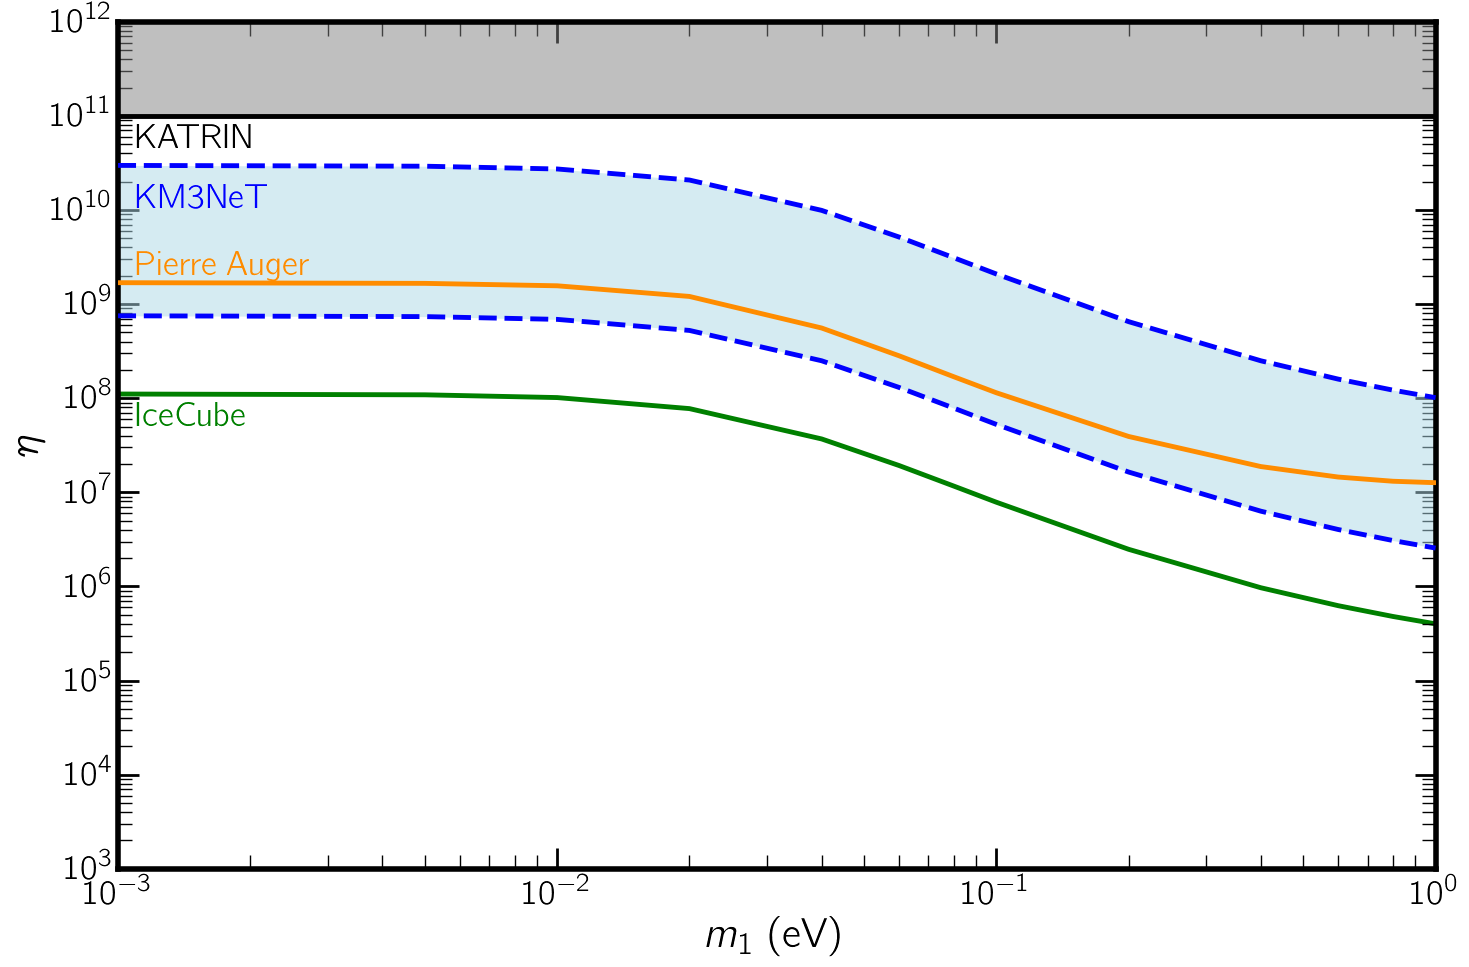

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for plotted lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers font size
label_fs = 30       # Axis labels font size
inline_text_fs = 25 # In-plot text labels font size
legend_fs = 20      # Legend font size (for potential future use)

plt.style.use('sty3.mplstyle')

def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1,
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=None,
                   text_on=True, label='', label_pos=[1e1, 1e-33], fontsize=inline_text_fs,
                   rotation=30, text_path_effects=None, textalpha=1, linestyle='-'):
    """
    Plot a constraint curve from a CSV file.
    """
    try:
        # Load the CSV file, specifying comma as the delimiter
        dat = np.loadtxt(filepath, delimiter=',')
        if filled:
            # Fill above the curve: from dat[:, 1] to a large value
            ax.fill_between(dat[:, 0], dat[:, 1], y2=1e15, color=facecolor, alpha=facealpha, zorder=fill_zorder, lw=0)
        ax.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw, path_effects=path_effects, alpha=edgealpha, zorder=zorder)

        if text_on:
            ax.text(label_pos[0], label_pos[1], label, fontsize=fontsize,
                    color=edgecolor, rotation=rotation, path_effects=text_path_effects, clip_on=True, alpha=textalpha, rotation_mode='anchor')
        return dat
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup File Path ---
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(script_dir, '../data/')
filepath_icecube = os.path.join(data_dir, 'mv0_eta_QSO_icecube.csv')
filepath_auger = os.path.join(data_dir, 'mv0_eta_QSO_auger.csv')
filepath_km3net_up = os.path.join(data_dir, 'mv0_eta_QSO_km3net_up.csv')
filepath_km3net_down = os.path.join(data_dir, 'mv0_eta_QSO_km3net_down.csv')

# --- Plot IceCube Data (Green Line, No Fill) ---
PlotConstraint(ax, filepath_icecube, filled=False, edgecolor='green', facecolor='lightblue', facealpha=0.5,
               label='IceCube', label_pos=[1.1e-3, 5e7], rotation=0, fontsize=inline_text_fs, zorder=1, lw=base_line_lw)

# --- Plot Auger Data (Orange Line, No Fill) ---
PlotConstraint(ax, filepath_auger, filled=False, edgecolor='#FF8C00', facecolor='lightblue', facealpha=0.7,
               label='Pierre Auger', label_pos=[1.1e-3, 2e9], rotation=0, fontsize=inline_text_fs, zorder=5, lw=base_line_lw)

# --- Plot KM3NeT Up and Down (Blue Lines, Fill Between) ---
# Plot the upper line with the KM3NeT label
dat_up = PlotConstraint(ax, filepath_km3net_up, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                        label='KM3NeT', label_pos=[1.1e-3, 1e10], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, linestyle='--')

# Plot the lower line (no label to avoid duplication)
dat_down = PlotConstraint(ax, filepath_km3net_down, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                          label='', label_pos=[1.1e-3, 5.5e9], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, text_on=False, linestyle='--')

# Fill between the upper and lower lines with light blue
if dat_up is not None and dat_down is not None:
    ax.fill_between(dat_up[:, 0], dat_down[:, 1], dat_up[:, 1], color='lightblue', alpha=0.5, zorder=2, lw=0)

# --- Add Horizontal Line for KATRIN at y = 9.95e10 (Gray Solid Line) with Fill Above ---
katrin_y = 9.95e10
ax.axhline(y=katrin_y, color='black', linestyle='-', lw=base_line_lw, zorder=3)

# Add gray fill above the KATRIN line
x_range = ax.get_xlim()  # Get the x-axis range for filling
ax.fill_between(x_range, katrin_y, 1e15, color='gray', alpha=0.5, zorder=2, lw=0)

# Add KATRIN label
ax.text(1.1e-3, 4.5e10, 'KATRIN', fontsize=inline_text_fs, color='black', rotation=0, clip_on=True)

# --- Set Axes ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-3, 1e0])  # Adjusted for mv0 range
ax.set_ylim([1e3, 1e12])  # Adjusted for eta range
ax.set_xlabel(r'$m_1$ (eV)', fontsize=label_fs)
ax.set_ylabel(r'$\eta$', fontsize=label_fs)

# Apply tick font size
ax.tick_params(axis='both', which='major', labelsize=tick_fs)
ax.tick_params(axis='both', which='minor', labelsize=tick_fs)

# Apply spine width
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)

plt.savefig('../plots/mv0_eta_QSO_combined.pdf', transparent=False, bbox_inches='tight')

plt.show()

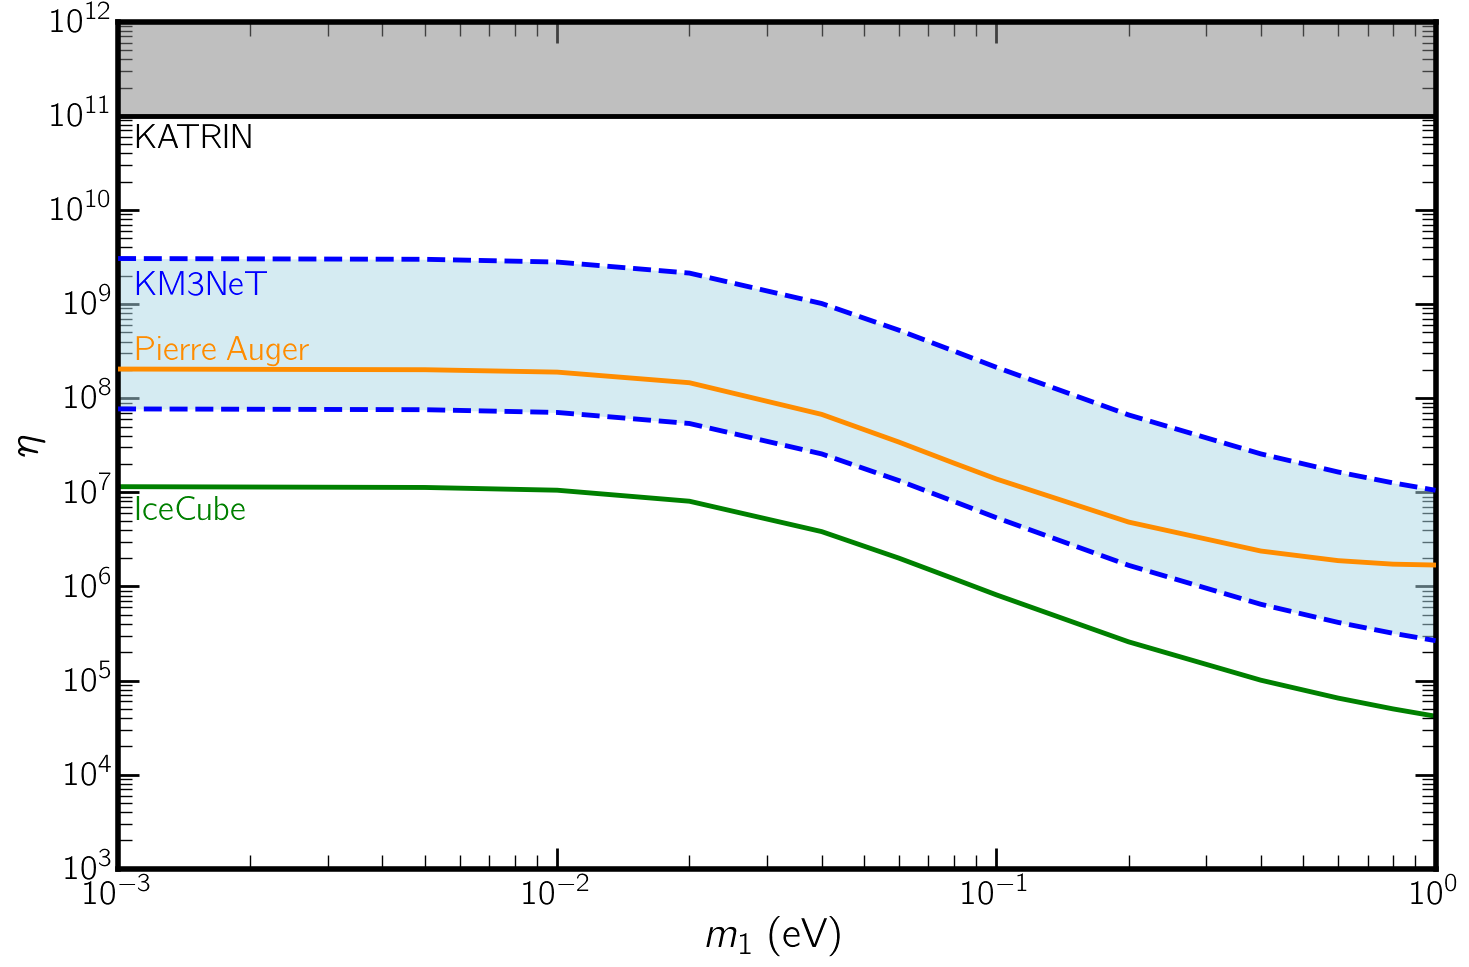

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for plotted lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers font size
label_fs = 30       # Axis labels font size
inline_text_fs = 25 # In-plot text labels font size
legend_fs = 20      # Legend font size (for potential future use)

plt.style.use('sty3.mplstyle')

def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1,
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=None,
                   text_on=True, label='', label_pos=[1e1, 1e-33], fontsize=inline_text_fs,
                   rotation=30, text_path_effects=None, textalpha=1, linestyle='-'):
    """
    Plot a constraint curve from a CSV file.
    """
    try:
        # Load the CSV file, specifying comma as the delimiter
        dat = np.loadtxt(filepath, delimiter=',')
        if filled:
            # Fill above the curve: from dat[:, 1] to a large value
            ax.fill_between(dat[:, 0], dat[:, 1], y2=1e15, color=facecolor, alpha=facealpha, zorder=fill_zorder, lw=0)
        ax.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw, path_effects=path_effects, alpha=edgealpha, zorder=zorder)

        if text_on:
            ax.text(label_pos[0], label_pos[1], label, fontsize=fontsize,
                    color=edgecolor, rotation=rotation, path_effects=text_path_effects, clip_on=True, alpha=textalpha, rotation_mode='anchor')
        return dat
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup File Path ---
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(script_dir, '../data/')
filepath_icecube = os.path.join(data_dir, 'mv0_eta_GRB_icecube.csv')
filepath_auger = os.path.join(data_dir, 'mv0_eta_GRB_auger.csv')
filepath_km3net_up = os.path.join(data_dir, 'mv0_eta_GRB_km3net_up.csv')
filepath_km3net_down = os.path.join(data_dir, 'mv0_eta_GRB_km3net_down.csv')

# --- Plot IceCube Data (Green Line, No Fill) ---
PlotConstraint(ax, filepath_icecube, filled=False, edgecolor='green', facecolor='lightblue', facealpha=0.5,
               label='IceCube', label_pos=[1.1e-3, 5e6], rotation=0, fontsize=inline_text_fs, zorder=1, lw=base_line_lw)

# --- Plot Auger Data (Orange Line, No Fill) ---
PlotConstraint(ax, filepath_auger, filled=False, edgecolor='#FF8C00', facecolor='lightblue', facealpha=0.7,
               label='Pierre Auger', label_pos=[1.1e-3, 2.5e8], rotation=0, fontsize=inline_text_fs, zorder=5, lw=base_line_lw)

# --- Plot KM3NeT Up and Down (Blue Lines, Fill Between) ---
# Plot the upper line with the KM3NeT label
dat_up = PlotConstraint(ax, filepath_km3net_up, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                        label='KM3NeT', label_pos=[1.1e-3, 1.2e9], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, linestyle='--')

# Plot the lower line (no label to avoid duplication)
dat_down = PlotConstraint(ax, filepath_km3net_down, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                          label='', label_pos=[1.1e-3, 4.5e9], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, text_on=False, linestyle='--')

# Fill between the upper and lower lines with light blue
if dat_up is not None and dat_down is not None:
    ax.fill_between(dat_up[:, 0], dat_down[:, 1], dat_up[:, 1], color='lightblue', alpha=0.5, zorder=2, lw=0)

# --- Add Horizontal Line for KATRIN at y = 9.95e10 (Gray Solid Line) with Fill Above ---
katrin_y = 9.95e10
ax.axhline(y=katrin_y, color='black', linestyle='-', lw=base_line_lw, zorder=3)

# Add gray fill above the KATRIN line
x_range = ax.get_xlim()  # Get the x-axis range for filling
ax.fill_between(x_range, katrin_y, 1e15, color='gray', alpha=0.5, zorder=2, lw=0)

# Add KATRIN label
ax.text(1.1e-3, 4.5e10, 'KATRIN', fontsize=inline_text_fs, color='black', rotation=0, clip_on=True)

# --- Set Axes ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-3, 1e0])  # Adjusted for mv0 range
ax.set_ylim([1e3, 1e12])  # Adjusted for eta range
ax.set_xlabel(r'$m_1$ (eV)', fontsize=label_fs)
ax.set_ylabel(r'$\eta$', fontsize=label_fs)

# Apply tick font size
ax.tick_params(axis='both', which='major', labelsize=tick_fs)
ax.tick_params(axis='both', which='minor', labelsize=tick_fs)

# Apply spine width
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)

plt.savefig('../plots/mv0_eta_GRB_combined.pdf', transparent=False, bbox_inches='tight')

plt.show()

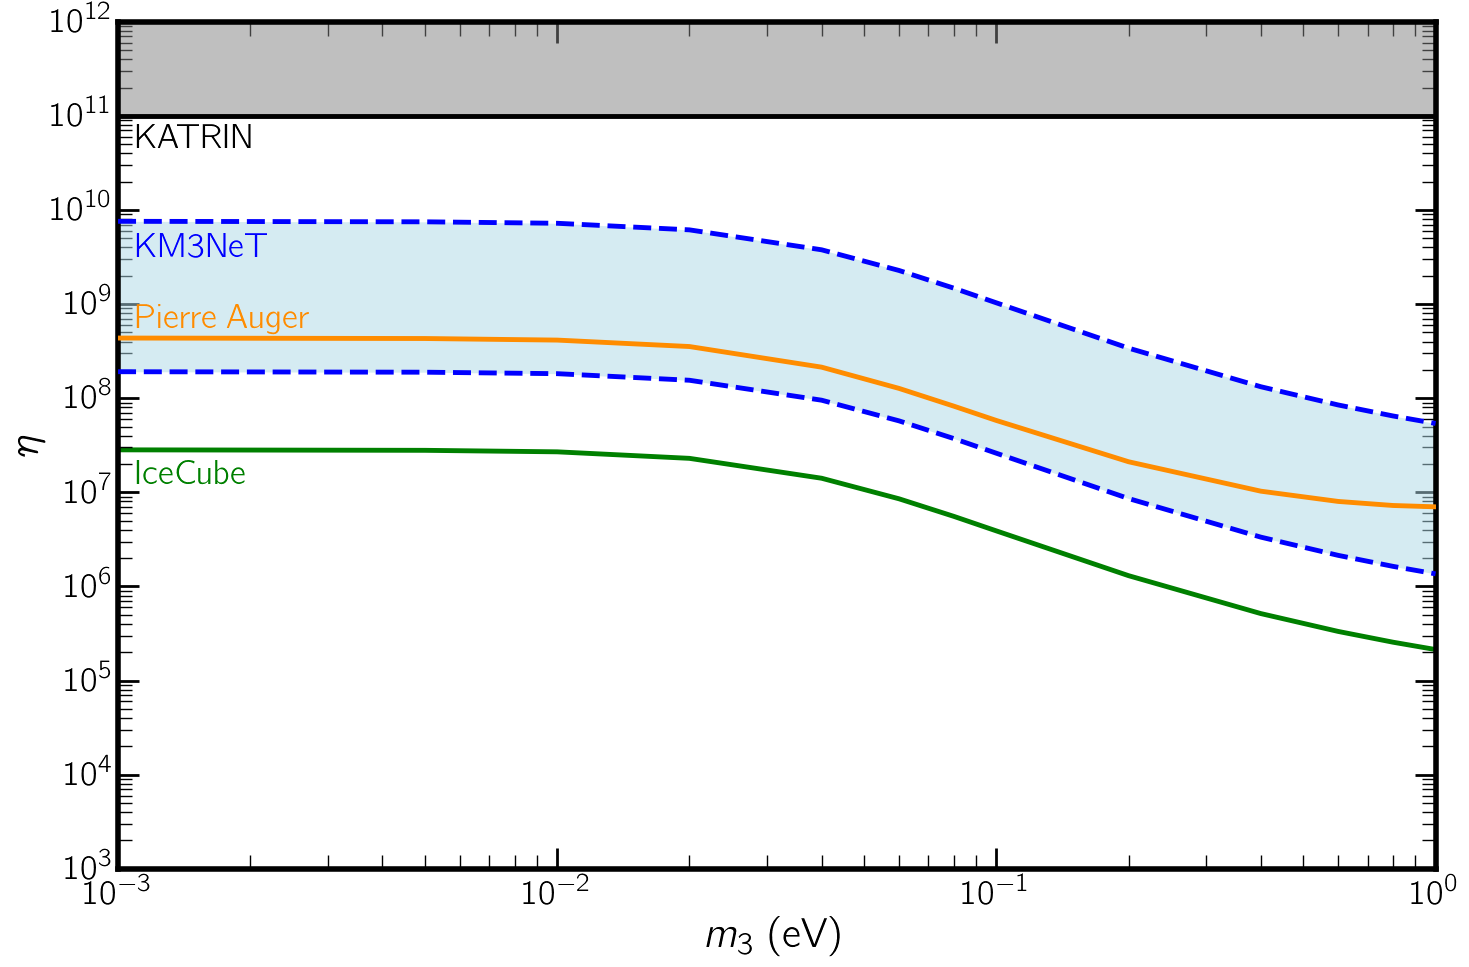

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for plotted lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers font size
label_fs = 30       # Axis labels font size
inline_text_fs = 25 # In-plot text labels font size
legend_fs = 20      # Legend font size (for potential future use)

plt.style.use('sty3.mplstyle')

def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1,
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=None,
                   text_on=True, label='', label_pos=[1e1, 1e-33], fontsize=inline_text_fs,
                   rotation=30, text_path_effects=None, textalpha=1, linestyle='-'):
    """
    Plot a constraint curve from a CSV file.
    """
    try:
        # Load the CSV file, specifying comma as the delimiter
        dat = np.loadtxt(filepath, delimiter=',')
        if filled:
            # Fill above the curve: from dat[:, 1] to a large value
            ax.fill_between(dat[:, 0], dat[:, 1], y2=1e15, color=facecolor, alpha=facealpha, zorder=fill_zorder, lw=0)
        ax.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw, path_effects=path_effects, alpha=edgealpha, zorder=zorder)

        if text_on:
            ax.text(label_pos[0], label_pos[1], label, fontsize=fontsize,
                    color=edgecolor, rotation=rotation, path_effects=text_path_effects, clip_on=True, alpha=textalpha, rotation_mode='anchor')
        return dat
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup File Path ---
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(script_dir, '../data/')
filepath_icecube = os.path.join(data_dir, 'mv0_eta_SFRI_icecube.csv')
filepath_auger = os.path.join(data_dir, 'mv0_eta_SFRI_auger.csv')
filepath_km3net_up = os.path.join(data_dir, 'mv0_eta_SFRI_km3net_up.csv')
filepath_km3net_down = os.path.join(data_dir, 'mv0_eta_SFRI_km3net_down.csv')

# --- Plot IceCube Data (Green Line, No Fill) ---
PlotConstraint(ax, filepath_icecube, filled=False, edgecolor='green', facecolor='lightblue', facealpha=0.5,
               label='IceCube', label_pos=[1.1e-3, 1.2e7], rotation=0, fontsize=inline_text_fs, zorder=1, lw=base_line_lw)

# --- Plot Auger Data (Orange Line, No Fill) ---
PlotConstraint(ax, filepath_auger, filled=False, edgecolor='#FF8C00', facecolor='lightblue', facealpha=0.7,
               label='Pierre Auger', label_pos=[1.1e-3, 5.5e8], rotation=0, fontsize=inline_text_fs, zorder=5, lw=base_line_lw)

# --- Plot KM3NeT Up and Down (Blue Lines, Fill Between) ---
# Plot the upper line with the KM3NeT label
dat_up = PlotConstraint(ax, filepath_km3net_up, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                        label='KM3NeT', label_pos=[1.1e-3, 3e9], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, linestyle='--')

# Plot the lower line (no label to avoid duplication)
dat_down = PlotConstraint(ax, filepath_km3net_down, filled=False, edgecolor='blue', facecolor='lightblue', facealpha=0.5,
                          label='', label_pos=[1.1e-3, 4.5e9], rotation=0, fontsize=inline_text_fs, zorder=3, lw=base_line_lw, text_on=False, linestyle='--')

# Fill between the upper and lower lines with light blue
if dat_up is not None and dat_down is not None:
    ax.fill_between(dat_up[:, 0], dat_down[:, 1], dat_up[:, 1], color='lightblue', alpha=0.5, zorder=2, lw=0)

# --- Add Horizontal Line for KATRIN at y = 9.95e10 (Gray Solid Line) with Fill Above ---
katrin_y = 9.95e10
ax.axhline(y=katrin_y, color='black', linestyle='-', lw=base_line_lw, zorder=3)

# Add gray fill above the KATRIN line
x_range = ax.get_xlim()  # Get the x-axis range for filling
ax.fill_between(x_range, katrin_y, 1e15, color='gray', alpha=0.5, zorder=2, lw=0)

# Add KATRIN label
ax.text(1.1e-3, 4.5e10, 'KATRIN', fontsize=inline_text_fs, color='black', rotation=0, clip_on=True)

# --- Set Axes ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-3, 1e0])  # Adjusted for mv0 range
ax.set_ylim([1e3, 1e12])  # Adjusted for eta range
ax.set_xlabel(r'$m_3$ (eV)', fontsize=label_fs)
ax.set_ylabel(r'$\eta$', fontsize=label_fs)

# Apply tick font size
ax.tick_params(axis='both', which='major', labelsize=tick_fs)
ax.tick_params(axis='both', which='minor', labelsize=tick_fs)

# Apply spine width
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)

plt.savefig('../plots/mv0_eta_SFR_IN_combined.pdf', transparent=False, bbox_inches='tight')

plt.show()

--- Applying y-axis scaling factor for all-flavor flux: 3.0 ---
--- Scaling both data point centers AND error lengths for log-scale visual consistency ---
Using style file: sty.mplstyle
Using Overdensity Factor: 1.0e+08
Data directory resolved to: /Users/zjj/Desktop/CnuB/code/../data/
Plot directory resolved to: /Users/zjj/Desktop/CnuB/code/../plots/
Processing 9 files for prefix 'SFRI-100'...
Plotted scaled summed and transformed data for 'SFRI-100'.
Processing 9 files for prefix 'SFRI-50'...
Plotted scaled summed and transformed data for 'SFRI-50'.
Processing 9 files for prefix 'SFRI-10'...
Plotted scaled summed and transformed data for 'SFRI-10'.
Note: Final Y-axis limits set to (1e-10, 1e-06) (scaled).
Saved scaled plot to /Users/zjj/Desktop/CnuB/code/../plots/all-flux-SFR-IN.pdf


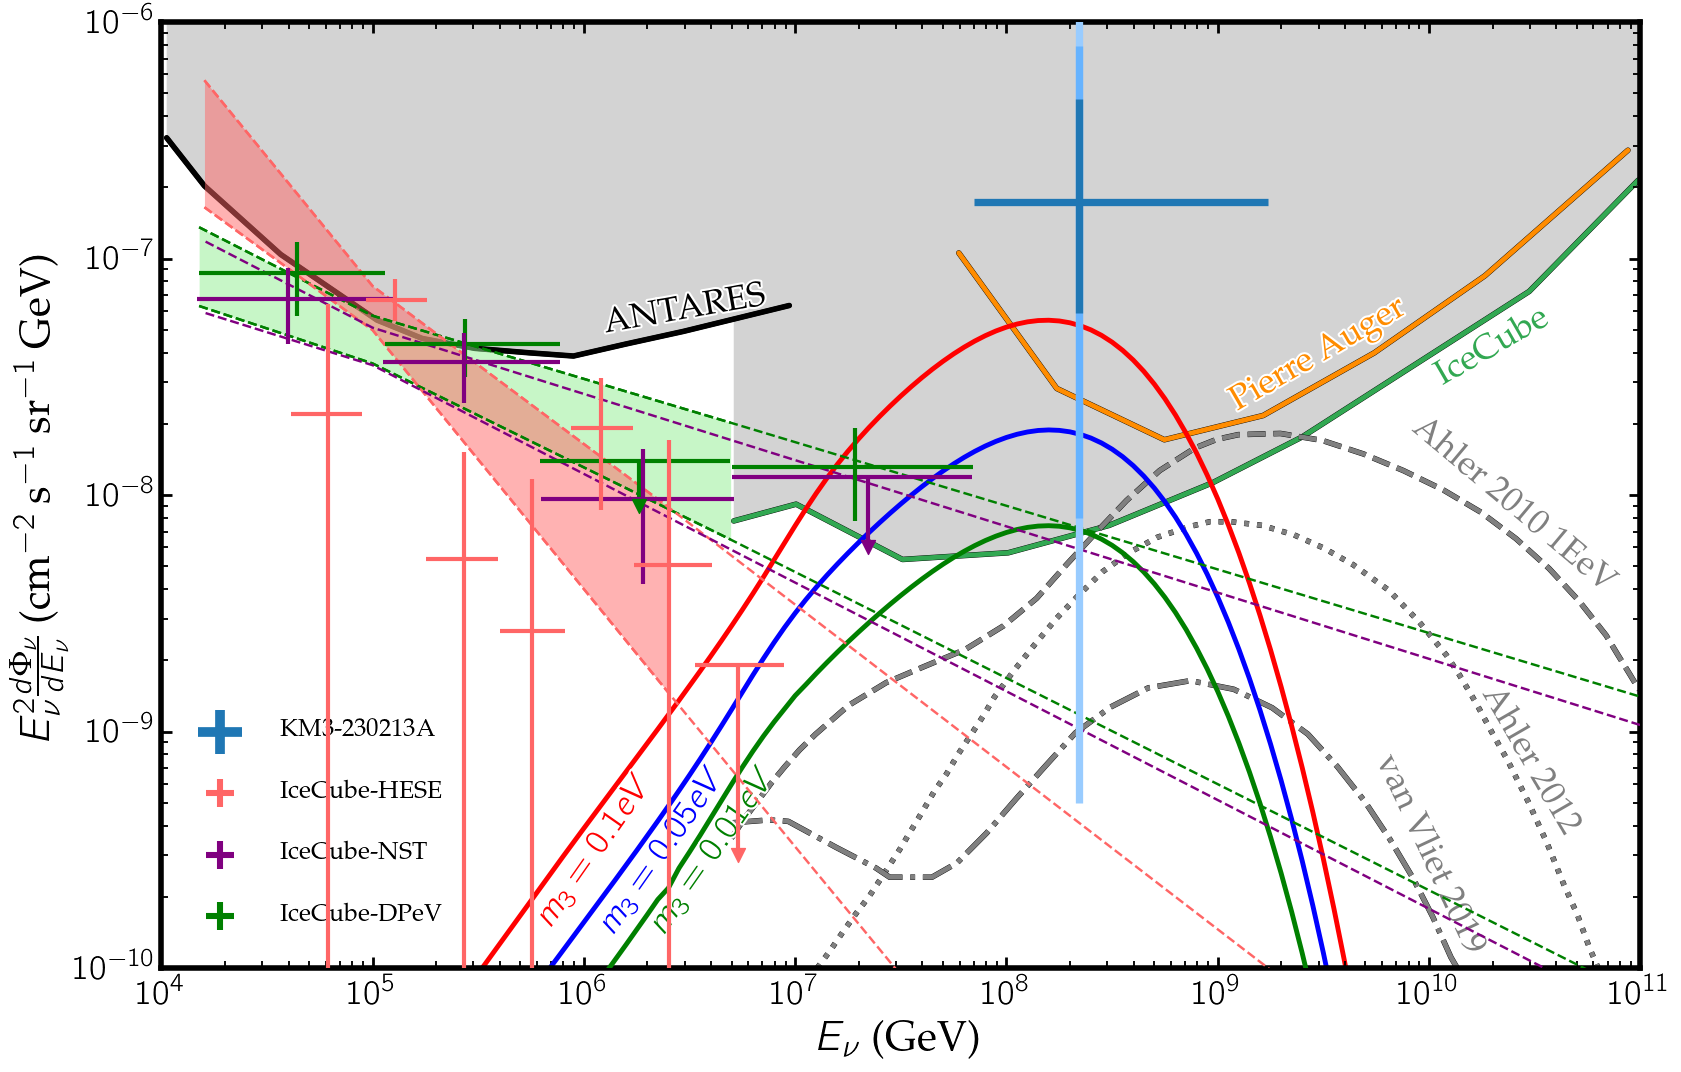

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D  # For custom legend
from matplotlib.patches import Rectangle # For filled box legend entries
import glob
import os

# --- Configuration ---
base_line_lw = 3.5
thin_line_lw = base_line_lw / 2
km3net_lw = base_line_lw * 1.5
spine_lw = 4.0
tick_fs = 25
label_fs = 30
inline_text_fs = 25
legend_fs = 18
# --- Legend Marker Specific Configurations ---
marker_size = 20    # Size for '+' markers
cross_lw = km3net_lw / 1.2 # Linewidth for '+' markers
box_size = 0.04     # Size of the filled box markers
box_lw = 1.5 * 3    # Linewidth for box markers (Increased x3)
line_lw = base_line_lw # Linewidth for line markers (Not used anymore for Auger)

# --- Scaling Factor for All-Flavor Flux ---
scaling_factor = 3.0 # Multiply y-values by this factor
print(f"--- Applying y-axis scaling factor for all-flavor flux: {scaling_factor:.1f} ---")
print("--- Scaling both data point centers AND error lengths for log-scale visual consistency ---")

# --- Style File Check ---
style_path = 'sty.mplstyle'
if os.path.exists(style_path):
    plt.style.use(style_path)
    print(f"Using style file: {style_path}")
else:
    print(f"Warning: Style file '{style_path}' not found. Using default Matplotlib styles.")

# --- Path Effects for Text ---
text_path_effects = [pe.withStroke(linewidth=3, foreground='white')]

# --- PlotConstraint Function (Scaled) ---
def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', filled=True, fill_zorder=-1, zorder=0, y2=1e6, # Increase y2 substantially
                   facecolor='green', edgecolor='darkgreen',
                   facealpha=1, edgealpha=1, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                   label_text='', label_pos=(1e7, 1e-8), rotation=0, text_color=None,
                   label='', textalpha=1, linestyle='-'):
    global scaling_factor
    try:
        dat = np.loadtxt(filepath, delimiter=',')
        dat[:, 1] *= scaling_factor # Scale Y data
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None

    line, = plt.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=edgecolor, lw=lw,
                     path_effects=path_effects, alpha=edgealpha, zorder=zorder)

    if filled:
        actual_fill_zorder = min(zorder - 0.1, fill_zorder)
        # Also scale the fill boundary if it's not effectively infinity
        fill_y2 = y2 * scaling_factor if y2 < 1e5 else y2 # Avoid scaling if y2 is already huge
        plt.fill_between(dat[:, 0], dat[:, 1], y2=fill_y2, color=facecolor, alpha=facealpha, zorder=actual_fill_zorder, lw=0)

    if label_text:
        text_c = text_color if text_color else edgecolor
        scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
        ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs,
                color=text_c, rotation=rotation, path_effects=text_path_effects,
                clip_on=True, alpha=textalpha, rotation_mode='anchor', ha='center', va='center')
    return line

# --- plot_sfri_sum Function (Scaled) ---
def plot_sfri_sum(ax, data_dir, prefix, color, linestyle,
                 label_text='', label_pos=(1e9, 1e-10), rotation=-45,
                 overdensity_factor=1.0, lw=base_line_lw, zorder=1):
    global scaling_factor
    search_pattern = os.path.join(data_dir, f"{prefix}-*.csv")
    file_list = sorted(glob.glob(search_pattern))
    if not file_list: print(f"Warning: No files found for prefix '{prefix}' with pattern '{search_pattern}'"); return
    print(f"Processing {len(file_list)} files for prefix '{prefix}'...")
    sum_y, base_x, first_file = None, None, True
    for filepath in file_list:
        try:
            dat = np.loadtxt(filepath, delimiter=',')
            if dat.ndim != 2 or dat.shape[1] < 2 or dat.shape[0] == 0: continue
            current_x, current_y = dat[:, 0], dat[:, 1]
            if first_file: base_x, sum_y, first_file = current_x, current_y.copy(), False
            else:
                if len(base_x) != len(current_x) or not np.allclose(base_x, current_x, atol=1e-8, rtol=1e-5):
                    print(f"Error: X-values mismatch in {os.path.basename(filepath)} for '{prefix}'. Skipping."); continue
                sum_y += current_y
        except Exception as e: print(f"Error processing {filepath}: {e}"); continue
    if sum_y is None or base_x is None: print(f"Warning: No sum for '{prefix}'."); return

    transformed_y = sum_y * (base_x ** 2) * overdensity_factor * scaling_factor # Scale Y data

    if np.any(np.isfinite(transformed_y)):
        ax.plot(base_x, transformed_y, color=color, linestyle=linestyle, lw=lw, zorder=zorder)
        print(f"Plotted scaled summed and transformed data for '{prefix}'.")
        if label_text:
            scaled_label_pos = (label_pos[0], label_pos[1] * scaling_factor) # Scale label Y position
            ax.text(scaled_label_pos[0], scaled_label_pos[1], label_text, fontsize=inline_text_fs, color=color, rotation=rotation,
                    path_effects=text_path_effects, clip_on=True, alpha=1.0, rotation_mode='anchor', ha='center', va='center')
    else: print(f"Warning: No finite values to plot for prefix '{prefix}'.")


# --- Main Plotting Logic ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

overdensity_factor = 1e8
print(f"Using Overdensity Factor: {overdensity_factor:.1e}")
base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_dir_rel, plot_dir_rel = '../data/', '../plots/'
data_dir, plot_dir = os.path.join(base_dir, data_dir_rel), os.path.join(base_dir, plot_dir_rel)
plot_png_dir = os.path.join(plot_dir, 'plots_png/')
os.makedirs(plot_dir, exist_ok=True); os.makedirs(plot_png_dir, exist_ok=True)
print(f"Data directory resolved to: {data_dir}")
print(f"Plot directory resolved to: {plot_dir}")

# --- Define Colors Consistently ---
icecube_color = '#32a852'
auger_color = '#FF8C00'
antares_color = 'black'
fill_color = 'lightgray'

# --- Plot IceCube, Auger, ANTARES, and New Lines (Scaled inside PlotConstraint) ---
icecube_label_pos, auger_label_pos, ANTARES95_label_pos = (2e10, 1.4e-8), (3e9, 1.3e-8), (3e6, 2e-8)
ahler2010_label_pos, ahler2012_label_pos, vliet2019_label_pos = (2.5e10, 3e-9), (3e10, 2.5e-10), (1e10, 1e-10)  # Individual positions to avoid overlap
icecube_rotation, auger_rotation, ANTARES95_rotation = 30, 30, 10
PlotConstraint(ax, os.path.join(data_dir, 'IceCube-12.6.csv'), filled=True, label_text='IceCube', label_pos=icecube_label_pos, rotation=icecube_rotation, edgecolor=icecube_color, facecolor=fill_color, zorder=0)
PlotConstraint(ax, os.path.join(data_dir, 'Auger.csv'), filled=False, label_text='Pierre Auger', text_color='#FF8C00', label_pos=auger_label_pos, rotation=auger_rotation, edgecolor=auger_color, zorder=0.5)
PlotConstraint(ax, os.path.join(data_dir, 'ANTARES95.csv'), filled=True, label_text='ANTARES', label_pos=ANTARES95_label_pos, rotation=ANTARES95_rotation, edgecolor=antares_color, facecolor=fill_color, zorder=0)
# Add new lines for Ahler 2010, Ahler 2012, and Vliet 2019 with individual label positions
PlotConstraint(ax, os.path.join(data_dir, 'ahler2010.csv'), filled=False, label_text='Ahler 2010 1EeV', label_pos=ahler2010_label_pos, rotation=-40, edgecolor='gray', linestyle='--', zorder=0)  # Dashed line
PlotConstraint(ax, os.path.join(data_dir, 'ahler2012.csv'), filled=False, label_text='Ahler 2012', label_pos=ahler2012_label_pos, rotation=-60, edgecolor='gray', linestyle=':', zorder=0)  # Dotted line
PlotConstraint(ax, os.path.join(data_dir, 'vliet2019.csv'), filled=False, label_text='van Vliet 2019', label_pos=vliet2019_label_pos, rotation=-65, edgecolor='gray', linestyle='-.', zorder=0)  # Dash-dot line

# --- SFRI Definitions & Plotting (Scaled inside plot_sfri_sum) ---
sfri_prefixes = ['SFRI-100', 'SFRI-50', 'SFRI-10']; sfri_colors = ['red', 'blue', 'green']; sfri_linestyles = ['-', '-', '-']
sfri_label_texts = {'SFRI-100': r'$m_3=0.1eV$', 'SFRI-50': r'$m_3=0.05eV$', 'SFRI-10': r'$m_3=0.01eV$'}
sfri_label_params = {'SFRI-100': (1.1e6, 1e-10, +55), 'SFRI-50': (2.3e6, 1e-10, +55), 'SFRI-10': (4e6, 1e-10, +55)}
for i, prefix in enumerate(sfri_prefixes):
    params = sfri_label_params.get(prefix, (1e9, 1e-11, -45)); label_txt = sfri_label_texts.get(prefix, prefix)
    plot_sfri_sum(ax, data_dir, prefix, color=sfri_colors[i % len(sfri_colors)], linestyle=sfri_linestyles[i % len(sfri_linestyles)], label_text=label_txt, label_pos=(params[0], params[1]), rotation=params[2], overdensity_factor=overdensity_factor, zorder=i + 1)

# --- Plot DPeV Fill (Scaled) ---
try:
    dpev_upper = np.loadtxt(os.path.join(data_dir, 'DpeV-up.csv'), delimiter=','); dpev_lower = np.loadtxt(os.path.join(data_dir, 'DpeV-down.csv'), delimiter=',')
    dpev_upper[:, 1] *= scaling_factor # Scale Y data
    dpev_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(dpev_upper[:, 0], dpev_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(dpev_upper[:, 0], dpev_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(dpev_lower[:, 0], dpev_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(dpev_upper[:, 0], dpev_lower[:, 1], dpev_upper[:, 1], color='lightgreen', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: DPeV x values misaligned.")
except Exception as e: print(f"Error processing DPeV files: {e}")

# --- Plot HEST Fill (Scaled) ---
try:
    hest_upper = np.loadtxt(os.path.join(data_dir, 'HEST-up.csv'), delimiter=','); hest_lower = np.loadtxt(os.path.join(data_dir, 'HEST-down.csv'), delimiter=',')
    hest_upper[:, 1] *= scaling_factor # Scale Y data
    hest_lower[:, 1] *= scaling_factor # Scale Y data
    if np.allclose(hest_upper[:, 0], hest_lower[:, 0], atol=1e-8, rtol=1e-5):
        ax.plot(hest_upper[:, 0], hest_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.plot(hest_lower[:, 0], hest_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=2)
        ax.fill_between(hest_upper[:, 0], hest_lower[:, 1], hest_upper[:, 1], color='#FF6666', alpha=0.5, zorder=1, lw=0)
    else: print("Warning: HEST x values misaligned.")
except Exception as e: print(f"Error processing HEST files: {e}")

# --- Plot Dashed Lines (DPeVall, HESTall, NSTall) (Scaled) ---
try:
    dpevall_upper = np.loadtxt(os.path.join(data_dir, 'DPeVall-up.csv'), delimiter=','); dpevall_lower = np.loadtxt(os.path.join(data_dir, 'DPeVall-down.csv'), delimiter=',')
    hestall_upper = np.loadtxt(os.path.join(data_dir, 'HESTall-up.csv'), delimiter=','); hestall_lower = np.loadtxt(os.path.join(data_dir, 'HESTall-down.csv'), delimiter=',')
    nstall_upper = np.loadtxt(os.path.join(data_dir, 'NSTall-up.csv'), delimiter=','); nstall_lower = np.loadtxt(os.path.join(data_dir, 'NSTall-down.csv'), delimiter=',')

    dpevall_upper[:, 1] *= scaling_factor; dpevall_lower[:, 1] *= scaling_factor # Scale Y
    hestall_upper[:, 1] *= scaling_factor; hestall_lower[:, 1] *= scaling_factor # Scale Y
    nstall_upper[:, 1] *= scaling_factor; nstall_lower[:, 1] *= scaling_factor # Scale Y

    ax.plot(dpevall_upper[:, 0], dpevall_upper[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(dpevall_lower[:, 0], dpevall_lower[:, 1], color='green', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(hestall_upper[:, 0], hestall_upper[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(hestall_lower[:, 0], hestall_lower[:, 1], color='#FF6666', linestyle='--', lw=thin_line_lw, zorder=3)
    ax.plot(nstall_upper[:, 0], nstall_upper[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3); ax.plot(nstall_lower[:, 0], nstall_lower[:, 1], color='purple', linestyle='--', lw=thin_line_lw, zorder=3)
except Exception as e: print(f"Error processing dashed line files: {e}")


# --- Add Special Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
x_center_green_orig, y_center_green_orig, y_lower_green_orig = 1.82e6, 4.63e-9, 3e-9
x_err_green = [[1.2e6], [3.1e6]] # X error unchanged
y_center_green_scaled = y_center_green_orig * scaling_factor # Scale center y
y_lower_green_scaled = y_lower_green_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_green_scaled - y_lower_green_scaled # Calculate scaled error length
y_err_green_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_green_orig, y_center_green_scaled, xerr=x_err_green, yerr=y_err_green_scaled, fmt=' ', color='green', ecolor='green', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_green_orig, y_lower_green_scaled, color='green', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_pink_orig, y_center_pink_orig, y_lower_pink_orig = 5.36e6, 6.36e-10, 1e-10
x_err_pink = [[2e6], [3.5e6]] # X error unchanged
y_center_pink_scaled = y_center_pink_orig * scaling_factor # Scale center y
y_lower_pink_scaled = y_lower_pink_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_pink_scaled - y_lower_pink_scaled # Calculate scaled error length
y_err_pink_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_pink_orig, y_center_pink_scaled, xerr=x_err_pink, yerr=y_err_pink_scaled, fmt=' ', color='#FF6666', ecolor='#FF6666', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_pink_orig, y_lower_pink_scaled, color='#FF6666', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos

x_center_purple_orig, y_center_purple_orig, y_lower_purple_orig = 2.2e7, 3.98e-9, 2e-9
x_err_purple = [[1.7e7], [4.7e7]] # X error unchanged
y_center_purple_scaled = y_center_purple_orig * scaling_factor # Scale center y
y_lower_purple_scaled = y_lower_purple_orig * scaling_factor # Scale lower marker y
y_err_down_scaled = y_center_purple_scaled - y_lower_purple_scaled # Calculate scaled error length
y_err_purple_scaled = [[y_err_down_scaled], [0]] # Define error with scaled length
ax.errorbar(x_center_purple_orig, y_center_purple_scaled, xerr=x_err_purple, yerr=y_err_purple_scaled, fmt=' ', color='purple', ecolor='purple', capsize=0, zorder=10) # Plot with scaled center & error
ax.scatter(x_center_purple_orig, y_lower_purple_scaled, color='purple', marker='v', s=100, zorder=11) # Plot marker at scaled lower pos


# --- Add Normal Error Bars (SCALED CENTERS AND SCALED ERROR LENGTHS for log vis) ---
error_bars = {
    'green': {'centers': [(4.4e4, 2.9e-8), (2.75e5, 1.45e-8), (1.92e7, 4.38e-9)], 'x_errs': [(2.9e4, 7e4), (1.6e5, 5e5), (1.42e7, 5e7)], 'y_errs': [(1e-8, 1e-8), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    'purple': {'centers': [(3.97e4, 2.25e-8), (2.72e5, 1.22e-8), (1.91e6, 3.2e-9)], 'x_errs': [(2.5e4, 8.6e4), (1.6e5, 5e5), (1.28e6, 3.2e6)], 'y_errs': [(8e-9, 8e-9), (4e-9, 4e-9), (1.8e-9, 2e-9)]},
    '#FF6666': {'centers': [(6.13e4, 7.33e-9), (1.28e5, 2.22e-8), (2.72e5, 1.78e-9), (5.7e5, 8.87e-10), (1.2e6, 6.38e-9), (2.53e6, 1.68e-9)], 'x_errs': [(2e4, 2.8e4), (3.5e4, 5.2e4), (9.3e4, 1.2e5), (1.7e5, 2.4e5), (3.3e5, 5e5), (8e5, 1.5e6)], 'y_errs': [(4e-8, 1.4e-8), (4e-9, 5e-9), (2e-8, 3.3e-9), (4e-8, 3e-9), (3.5e-9, 4e-9), (3e-8, 4e-9)]}
}
for color, data in error_bars.items():
    for (x, y_orig), (xl, xr), (yl_orig, yu_orig) in zip(data['centers'], data['x_errs'], data['y_errs']):
        # --- SCALING Center Point Y ---
        y_scaled = y_orig * scaling_factor
        # --- SCALING Error Lengths Y ---
        yl_scaled = yl_orig * scaling_factor
        yu_scaled = yu_orig * scaling_factor
        # --- Use scaled y, scaled yl, scaled yu ---
        ax.errorbar(x, y_scaled, xerr=[[xl], [xr]], yerr=[[yl_scaled], [yu_scaled]], fmt=' ', color=color, ecolor=color, capsize=0, zorder=10, label='_nolegend_')


# --- Add KM3NeT Error Bar (SCALED CENTER AND SCALED ERROR LENGTHS for log vis) ---
x_center_km3net_orig, y_center_km3net_orig = 2.2e8, 5.8e-8
x_err_km3net = [[1.5e8], [1.5e9]] # X error unchanged

# --- Scale center y ---
y_center_km3net_scaled = y_center_km3net_orig * scaling_factor

# --- Scale Y error lengths ---
y_err_1s_orig = [[1.15e-7], [3e-7]]
y_err_2s_orig = [[1.66e-7], [6.2e-7]]
y_err_3s_orig = [[1.735e-7], [9.1e-7]]

colors_km3net = ['#1f77b4', '#66b3ff', '#99ccff']

# Assuming the following variables are defined elsewhere in your code
# ax = ...  # Your matplotlib axes object
# x_center_km3net_orig = ...
# y_center_km3net_scaled = ...
# x_err_km3net = ...
# km3net_lw = ...

# --- Plot using scaled center and ORIGINAL error lengths ---
# The layering approach works correctly when lengths are scaled proportionally
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_1s_orig, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_2s_orig, fmt=' ', color=colors_km3net[1], ecolor=colors_km3net[1], lw=km3net_lw, capsize=0, zorder=11)
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_3s_orig, fmt=' ', color=colors_km3net[2], ecolor=colors_km3net[2], lw=km3net_lw, capsize=0, zorder=10)
# Plot X error bar relative to scaled center
ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, xerr=x_err_km3net, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12, label='_nolegend_')

# # --- Scale Y error lengths ---
# y_err_1s_orig = [[4e-8], [1.1e-7]]
# y_err_2s_orig = [[9.54e-8], [3.45e-7]]
# y_err_3s_orig = [[1.5325e-7], [7e-7]]

# y_err_1s_scaled = [[l * scaling_factor for l in y_err_1s_orig[0]], [u * scaling_factor for u in y_err_1s_orig[1]]]
# y_err_2s_scaled = [[l * scaling_factor for l in y_err_2s_orig[0]], [u * scaling_factor for u in y_err_2s_orig[1]]]
# y_err_3s_scaled = [[l * scaling_factor for l in y_err_3s_orig[0]], [u * scaling_factor for u in y_err_3s_orig[1]]]

# colors_km3net = ['#1f77b4', '#66b3ff', '#99ccff']

# # --- Plot using scaled center and SCALED error lengths ---
# # The layering approach works correctly when lengths are scaled proportionally
# ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_1s_scaled, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12)
# ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_2s_scaled, fmt=' ', color=colors_km3net[1], ecolor=colors_km3net[1], lw=km3net_lw, capsize=0, zorder=11)
# ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, yerr=y_err_3s_scaled, fmt=' ', color=colors_km3net[2], ecolor=colors_km3net[2], lw=km3net_lw, capsize=0, zorder=10)
# # Plot X error bar relative to scaled center
# ax.errorbar(x_center_km3net_orig, y_center_km3net_scaled, xerr=x_err_km3net, fmt=' ', color=colors_km3net[0], ecolor=colors_km3net[0], lw=km3net_lw, capsize=0, zorder=12, label='_nolegend_')


# --- Axis Settings ---
ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xlim([1e4, 1e11])
# --- SCALED Y-LIMITS ---
original_ylim = [1e-10, 1e-6]
scaled_ylim = [lim * 1 for lim in original_ylim]
ax.set_ylim(scaled_ylim)
# --- END SCALED Y-LIMITS ---
print(f"Note: Final Y-axis limits set to {ax.get_ylim()} (scaled).")
ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$E_{\nu}^{2} \frac{d\Phi_{\nu}}{dE_{\nu}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV)', fontsize=label_fs)
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=8)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=5)
for spine in ax.spines.values(): spine.set_linewidth(spine_lw)
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj); ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100))

# --- Add Custom Annotations (Legend) outside the plot (UNCHANGED) ---
legend_x_start = 0.08
marker_x_offset = -0.04
legend_y_start = 0.25
legend_y_step = 0.065
current_y = legend_y_start
# ... (rest of legend code is unchanged) ...
# 1. KM3NeT (Blue Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color=colors_km3net[0], ms=marker_size*1.6, mew=cross_lw*1.6, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "KM3-230213A", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 2. IceCube HEST (Pink Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='#FF6666', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 3. IceCube NST (Purple Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='purple', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-NST", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# 4. IceCube DPeV (Green Cross)
ax.plot([legend_x_start + marker_x_offset], [current_y], marker='+', color='green', ms=marker_size, mew=cross_lw, linestyle='None', transform=ax.transAxes, clip_on=False)
ax.text(legend_x_start, current_y, "IceCube-DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
current_y -= legend_y_step
# # 5. DPeV (Light Green Box - Thicker Border)
# nst_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='lightgreen', alpha=0.7, edgecolor='darkgreen', lw=box_lw)
# ax.add_patch(nst_box)
# ax.text(legend_x_start, current_y, "DPeV", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step
# # 6. HEST (Pink Box - Thicker Border)
# hest_box = Rectangle((legend_x_start + marker_x_offset - box_size/2, current_y - box_size/2), box_size, box_size, transform=ax.transAxes, clip_on=False, facecolor='#FF6666', alpha=0.7, edgecolor='#FF6666', lw=box_lw)
# ax.add_patch(hest_box)
# ax.text(legend_x_start, current_y, "HESE", transform=ax.transAxes, fontsize=legend_fs, ha='left', va='center', clip_on=False)
# current_y -= legend_y_step


# --- Adjust Layout and Save Plot ---
plt.subplots_adjust(left=0.09, right=0.96, top=0.96, bottom=0.1)

output_pdf = os.path.join(plot_dir, 'all-flux-SFR-IN.pdf')
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

try:
    plt.savefig(output_pdf, transparent=False)
    print(f"Saved scaled plot to {output_pdf}")
except Exception as e:
     print(f"Saving without bbox_inches='tight' failed: {e}. Trying with bbox_inches='tight'.")
     plt.savefig(output_pdf, transparent=False, bbox_inches='tight')
     print(f"Saved scaled plot to {output_pdf}")

# --- Display Plot ---
plt.show()

Plot saved to /Users/zjj/Desktop/CnuB/code/../plots/cosmic_ray_flux.pdf


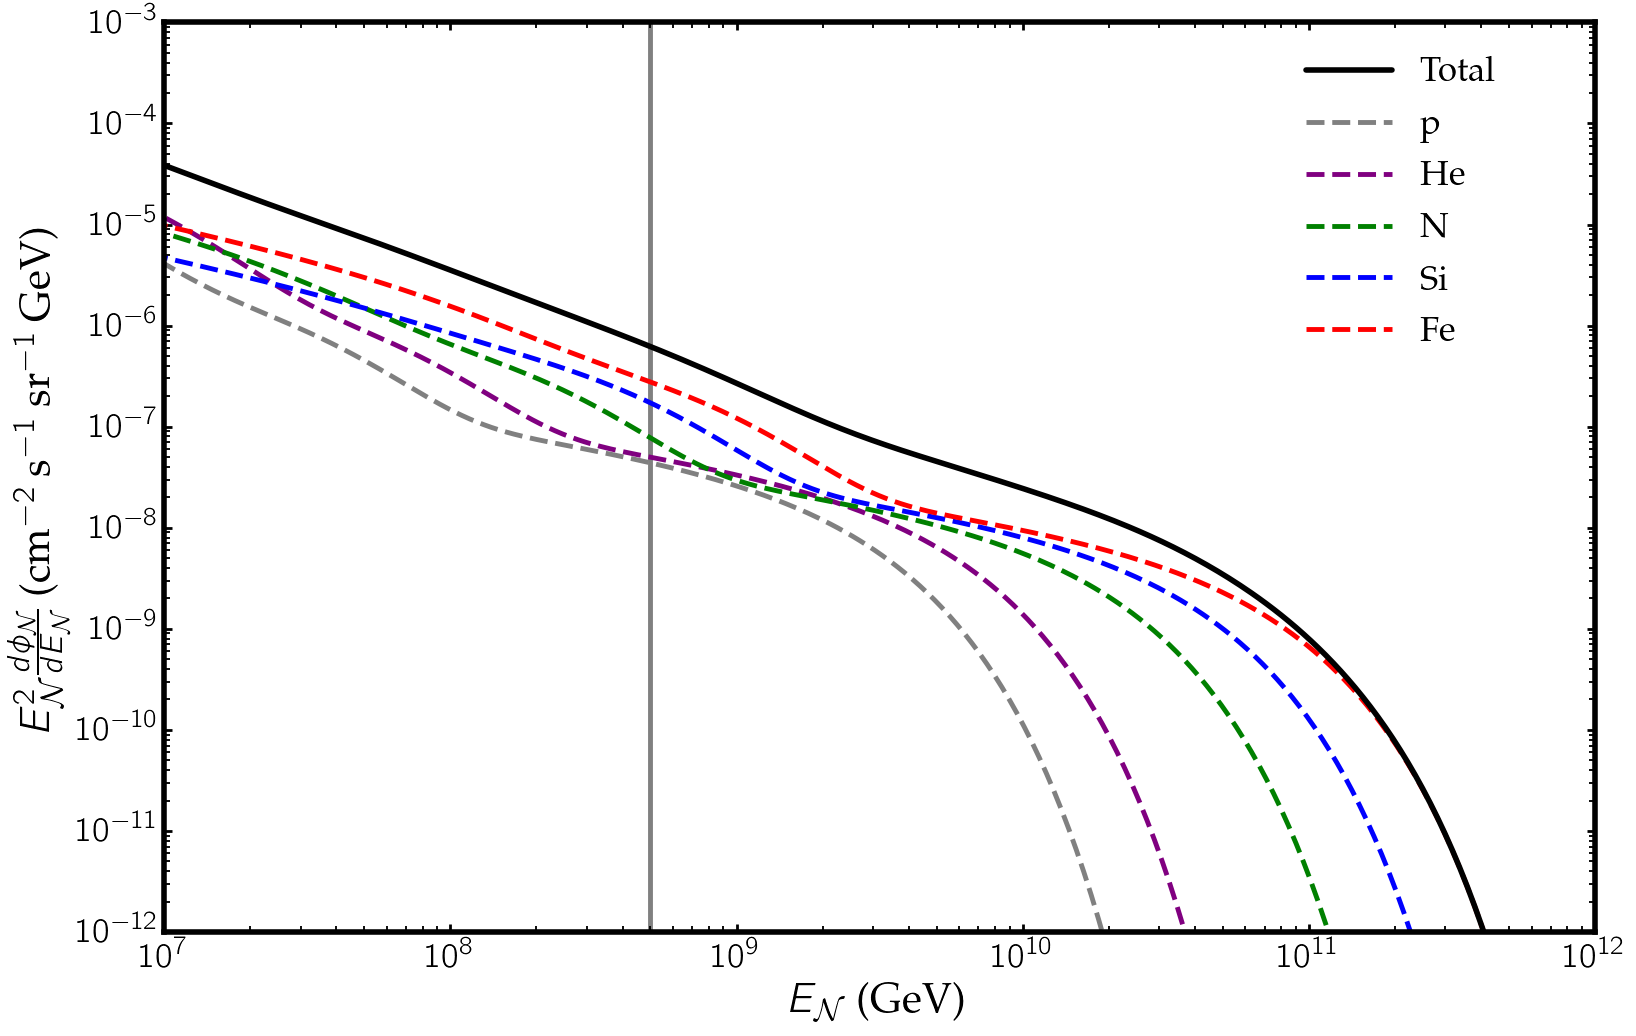

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

# --- Configuration ---
# Line Widths
line_lw = 3.5   # Base line width for data series
sum_line_lw = 4.0 # Line width for the sum line
spine_lw = 4.0   # Line width for the axis border/spines

# Font Sizes
tick_fs = 25    # Axis tick numbers (e.g., 10^3, 10^-16)
label_fs = 30   # Axis labels (e.g., E_nu [GeV])
legend_fs = 25  # Legend text

# Colors (matching Mathematica PlotStyle)
colors = {
    'proton': 'gray',
    'He': 'purple',
    'N': 'green',
    'Si': 'blue',
    'Fe': 'red',
    'sum': 'black'
}

# --- Define Cosmic Ray Parameters ---
cosmic_ray_params = {
    'proton': {'ap1': 7860, 'ap2': 20, 'ap3': 1.7, 'r1': 1.66, 'r2': 1.4, 'r3': 1.4, 'Zh': 1},
    'he': {'ap1': 3550, 'ap2': 20, 'ap3': 1.7, 'r1': 1.58, 'r2': 1.4, 'r3': 1.4, 'Zh': 2},
    'n': {'ap1': 2200, 'ap2': 13.4, 'ap3': 1.14, 'r1': 1.63, 'r2': 1.4, 'r3': 1.4, 'Zh': 7},
    'si': {'ap1': 1430, 'ap2': 13.4, 'ap3': 1.14, 'r1': 1.67, 'r2': 1.4, 'r3': 1.4, 'Zh': 14},
    'fe': {'ap1': 2120, 'ap2': 13.4, 'ap3': 1.14, 'r1': 1.63, 'r2': 1.4, 'r3': 1.4, 'Zh': 26}
}

# --- Define the Cosmic Ray Flux Function ---
def cosmic_ray_flux(nucleus_type, En):
    """Compute the cosmic ray flux for a given nucleus type and energy En (GeV)."""
    # Normalize nucleus type to lowercase
    nucleus_key = nucleus_type.lower()
    
    # Validate nucleus type
    if nucleus_key not in cosmic_ray_params:
        raise ValueError("Invalid nucleus type for cosmic ray flux. Choose from: proton, he, n, si, fe")
    
    # Retrieve parameters
    params = cosmic_ray_params[nucleus_key]
    ap1 = params['ap1']
    ap2 = params['ap2']
    ap3 = params['ap3']
    r1 = params['r1']
    r2 = params['r2']
    r3 = params['r3']
    Zh = params['Zh']
    
    # Compute the flux
    flux = (1 / 10**4) * (
        ap1 * En**(-r1 - 1) * np.exp(-(En / Zh) / (4 * 10**6)) +
        ap2 * En**(-r2 - 1) * np.exp(-(En / Zh) / (30 * 10**6)) +
        ap3 * En**(-r3 - 1) * np.exp(-(En / Zh) / (2 * 10**9))
    )
    return flux

# --- Setup File Paths ---
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
plot_dir = os.path.join(script_dir, '../plots/')
os.makedirs(plot_dir, exist_ok=True)

# --- Create Figure ---
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Compute and Plot the Fluxes ---
# Energy range (En from 10^1 to 10^14)
En = np.logspace(1, 14, 1000)  # 10^1 to 10^14, 1000 points

# List of nuclei to plot
nuclei = ['proton', 'He', 'N', 'Si', 'Fe']

# Compute flux for each nucleus and the sum
fluxes = {}
sum_flux = np.zeros_like(En)
for nucleus in nuclei:
    flux = cosmic_ray_flux(nucleus, En)
    fluxes[nucleus] = flux
    sum_flux += flux

# Plot individual fluxes (multiplied by En^2) with dashed lines
for nucleus in nuclei:
    ax.plot(En, En**2 * fluxes[nucleus], linestyle='--', color=colors[nucleus], lw=line_lw, label=nucleus)

# Plot the sum (multiplied by En^2)
ax.plot(En, En**2 * sum_flux, linestyle='solid', color=colors['sum'], lw=sum_line_lw, label='Sum')

# Add vertical line at 5e8 GeV
ax.axvline(x=5e8, color='gray', linestyle='-', lw=line_lw, zorder=0)

# --- Set Axes (Log-Log Scale) ---
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**7, 10**12])  # PlotRange x-axis
ax.set_ylim([10**-12, 10**-3])  # PlotRange y-axis

# Axis labels and styling
ax.set_xlabel(r'$E_\mathcal{N}$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$E_\mathcal{N}^2 \frac{d\phi_\mathcal{N}}{dE_\mathcal{N}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV)', fontsize=label_fs)
ax.tick_params(axis='both', which='major', labelsize=tick_fs, width=spine_lw/2, length=6)
ax.tick_params(axis='both', which='minor', width=spine_lw/3, length=4)

# Thicken axis spines
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

# --- Create Custom Legend ---
# Place "Total" at the top, and use dashed lines for individual elements
legend_elements = [
    Line2D([0], [0], color=colors['sum'], lw=sum_line_lw, linestyle='solid', label='Total'),
    Line2D([0], [0], color=colors['proton'], lw=line_lw, linestyle='--', label='p'),
    Line2D([0], [0], color=colors['He'], lw=line_lw, linestyle='--', label='He'),
    Line2D([0], [0], color=colors['N'], lw=line_lw, linestyle='--', label='N'),
    Line2D([0], [0], color=colors['Si'], lw=line_lw, linestyle='--', label='Si'),
    Line2D([0], [0], color=colors['Fe'], lw=line_lw, linestyle='--', label='Fe')
]

ax.legend(
    handles=legend_elements,
    loc='center right',
    fontsize=legend_fs,
    frameon=False,
    handlelength=2.5,
    handletextpad=0.8,
    labelspacing=0.5,
    borderpad=0.3,
    bbox_to_anchor=(0.95, 0.8)  # Matches Mathematica's Placed[{...}, {0.8, 0.7}]
)

# --- Final Adjustments ---
plt.tight_layout()

# --- Save and Show ---
output_filename = os.path.join(plot_dir, 'cosmic_ray_flux.pdf')
plt.savefig(output_filename, transparent=False, bbox_inches='tight')
print(f"Plot saved to {output_filename}")
plt.show()

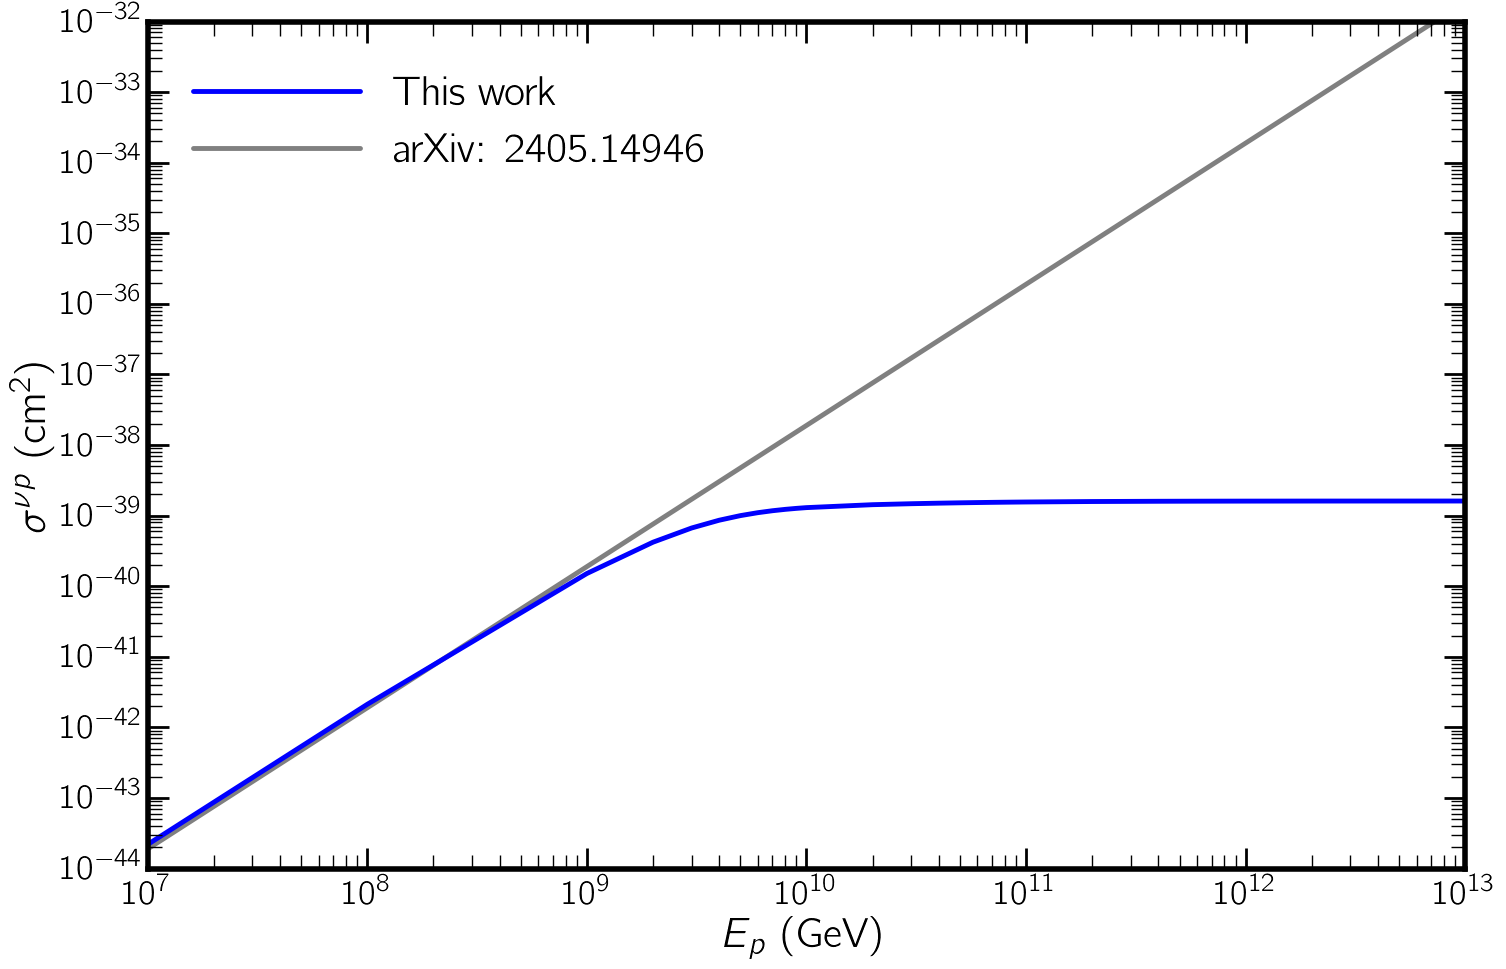

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import os

# --- Configuration ---
base_line_lw = 3.5  # Line width for plotted lines
spine_lw = 4.0      # Line width for axis spines
tick_fs = 25        # Axis tick numbers font size
label_fs = 30       # Axis labels font size
legend_fs = 30      # Legend font size

# Define a simplified PlotConstraint function for this use case
def PlotConstraint(ax, filepath, lw=base_line_lw, color='k', zorder=0, linestyle='-', label=''):
    """
    Plot a curve from a CSV file.
    """
    try:
        # Load the CSV file, assuming comma as the delimiter
        dat = np.loadtxt(filepath, delimiter=',')
        ax.plot(dat[:, 0], dat[:, 1], linestyle=linestyle, color=color, lw=lw, zorder=zorder, label=label)
        return dat
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Set up the figure and axis
fig = plt.figure(figsize=(17, 11))
ax = plt.subplot()

# --- Setup File Path ---
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
data_dir = os.path.join(script_dir, '../data/')
filepath_total_sigma_m01 = os.path.join(data_dir, 'total-sigma-m01.csv')
filepath_total_sigma_herrera = os.path.join(data_dir, 'total-sigma-Herrera.csv')

# --- Plot total-sigma-m01.csv (Blue Solid Line) ---
PlotConstraint(ax, filepath_total_sigma_m01, color='blue', zorder=1, linestyle='-', lw=base_line_lw)

# --- Plot total-sigma-Herrera.csv (Gray Solid Line) ---
PlotConstraint(ax, filepath_total_sigma_herrera, color='gray', zorder=0, linestyle='-', lw=base_line_lw)

# --- Create Custom Legend ---
legend_elements = [
    Line2D([0], [0], color='blue', lw=base_line_lw, linestyle='-', label='This work'),
    Line2D([0], [0], color='gray', lw=base_line_lw, linestyle='-', label='arXiv: 2405.14946')
]

ax.legend(
    handles=legend_elements,
    loc='center right',
    fontsize=legend_fs,
    frameon=False,
    handlelength=4,
    handletextpad=0.8,
    labelspacing=0.5,
    borderpad=0.3,
    bbox_to_anchor=(0.45, 0.88)
)

# --- Set Axes (Assuming similar scales as the original, adjust as needed) ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e7, 1e13])
ax.set_ylim([1e-44, 1e-32]) 
ax.set_xlabel(r'$E_p$ (GeV)', fontsize=label_fs)
ax.set_ylabel(r'$\sigma^{\nu p}$ (cm$^2$)', fontsize=label_fs) 

# Apply tick font size
ax.tick_params(axis='both', which='major', labelsize=tick_fs)
ax.tick_params(axis='both', which='minor', labelsize=tick_fs)

# Apply spine width
for spine in ax.spines.values():
    spine.set_linewidth(spine_lw)

# Set custom tick locators
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=50)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1, numticks=100)
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)

# Save the plot
plt.savefig('../plots/Compare.pdf', transparent=False, bbox_inches='tight')